<a href="https://colab.research.google.com/github/jithsg/MODELING/blob/main/Copy_of_Yet_another_copy_of_Yet_another_copy_of_Hybrid_pmos-4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.3 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# === X_scaled, y_combined must be defined from your preprocessing ===
# X_scaled → shape (n_samples, 6)
# y_combined → shape (n_samples, 3) [log10(Id), gm_scaled, gd_scaled]

X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

# === Optuna Objective Function ===
def objective(trial):
    # Loss term weights to tune
    w_Id   = trial.suggest_float("w_Id", 2.0, 6.0)
    w_gm   = trial.suggest_float("w_gm", 1.0, 4.0)
    w_gd   = trial.suggest_float("w_gd", 0.5, 2.0)
    w_gm_s = trial.suggest_float("w_gm_smooth", 0.001, 0.05)
    w_gd_s = trial.suggest_float("w_gd_smooth", 0.001, 0.05)
    w_gm_2 = trial.suggest_float("w_gm_second", 0.0001, 0.01)
    w_gd_2 = trial.suggest_float("w_gd_second", 0.0001, 0.01)

    # Define loss function with trial weights
    def hybrid_loss_opt(y_true, y_pred):
        log_Id_true = y_true[:, 0]
        gm_true     = y_true[:, 1]
        gd_true     = y_true[:, 2]

        log_Id_pred = y_pred[:, 0]
        gm_pred     = y_pred[:, 1]
        gd_pred     = y_pred[:, 2]

        loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
        loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
        loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

        gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
        gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

        gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
        gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

        return (
            w_Id * loss_Id +
            w_gm * loss_gm +
            w_gd * loss_gd +
            w_gm_s * gm_smooth +
            w_gd_s * gd_smooth +
            w_gm_2 * gm_second +
            w_gd_2 * gd_second
        )

    # Define model
    model = Sequential([
        Input(shape=(6,)),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(3)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss_opt)

    # Fit model
    model.fit(
        X_train_opt, y_train_opt,
        validation_data=(X_val_opt, y_val_opt),
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Evaluate validation I_ds MSE
    y_val_pred = model.predict(X_val_opt)
    log_Id_true = y_val_opt[:, 0]
    log_Id_pred = y_val_pred[:, 0]
    Id_true = 10 ** log_Id_true
    Id_pred = 10 ** log_Id_pred

    return mean_squared_error(Id_true, Id_pred)

# === Run Optuna Study ===
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# === Print Best Parameters ===
print("\nBest loss weights found:")
for key, val in study.best_params.items():
    print(f"{key}: {val:.4f}")


[I 2025-05-09 16:45:25,270] A new study created in memory with name: no-name-bb9b455c-ba27-4b0b-8588-4eca6f89fa6a


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-05-09 16:46:03,388] Trial 0 finished with value: 1.284293655411943e-10 and parameters: {'w_Id': 2.525108474635792, 'w_gm': 2.61870608267413, 'w_gd': 0.9552660127757965, 'w_gm_smooth': 0.02637151617074354, 'w_gd_smooth': 0.010370954638079976, 'w_gm_second': 0.008410063504682626, 'w_gd_second': 0.007545490410725906}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:46:31,632] Trial 1 finished with value: 2.328867075043509e-10 and parameters: {'w_Id': 5.74099868178114, 'w_gm': 1.6641366078491098, 'w_gd': 1.3376589533527865, 'w_gm_smooth': 0.03128062067905941, 'w_gd_smooth': 0.026971809292195507, 'w_gm_second': 0.008131869342449813, 'w_gd_second': 0.009763331966929547}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:04,126] Trial 2 finished with value: 2.1503969397893068e-10 and parameters: {'w_Id': 5.210864068713551, 'w_gm': 2.4567804855131286, 'w_gd': 1.4570894550492506, 'w_gm_smooth': 0.015235584068062104, 'w_gd_smooth': 0.047709953337632754, 'w_gm_second': 0.0002882898628717637, 'w_gd_second': 0.0037377452557540505}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:41,723] Trial 3 finished with value: 1.0970864292143141e-10 and parameters: {'w_Id': 2.5733139820865008, 'w_gm': 1.5636681338427767, 'w_gd': 1.2837947620985761, 'w_gm_smooth': 0.005339624499626156, 'w_gd_smooth': 0.03588261398845419, 'w_gm_second': 0.008090132286054482, 'w_gd_second': 0.0027249730445105293}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:07,795] Trial 4 finished with value: 4.449782141917571e-10 and parameters: {'w_Id': 5.714855843363008, 'w_gm': 1.431664774275986, 'w_gd': 0.8419695687128987, 'w_gm_smooth': 0.03766535518833621, 'w_gd_smooth': 0.0035263095019293887, 'w_gm_second': 0.0023090336595153857, 'w_gd_second': 0.001858558893205015}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:40,377] Trial 5 finished with value: 1.9872607084867326e-10 and parameters: {'w_Id': 4.921425905914983, 'w_gm': 3.210657016217744, 'w_gd': 1.182327338128778, 'w_gm_smooth': 0.048168578202739336, 'w_gd_smooth': 0.03648288624323011, 'w_gm_second': 0.0036606441085774615, 'w_gd_second': 0.009980825819554869}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:10,124] Trial 6 finished with value: 4.3163468879461184e-08 and parameters: {'w_Id': 2.6119603015713793, 'w_gm': 3.143202737796021, 'w_gd': 1.6282002708977306, 'w_gm_smooth': 0.0347554569935443, 'w_gd_smooth': 0.04850628519757475, 'w_gm_second': 0.0033917804592477154, 'w_gd_second': 0.008725303382350521}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:45,192] Trial 7 finished with value: 1.03582207529973e-10 and parameters: {'w_Id': 4.798155010651325, 'w_gm': 2.581478232440331, 'w_gd': 1.533429675828571, 'w_gm_smooth': 0.019438177938510603, 'w_gd_smooth': 0.02436087124893307, 'w_gm_second': 0.006481188064761129, 'w_gd_second': 0.006438926415808942}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:24,280] Trial 8 finished with value: 2.5170592503726784e-10 and parameters: {'w_Id': 3.3672755645470382, 'w_gm': 1.3935205002788558, 'w_gd': 0.7984867831772668, 'w_gm_smooth': 0.00655070023758318, 'w_gd_smooth': 0.005972494651898182, 'w_gm_second': 0.009701910218783177, 'w_gd_second': 0.006783040237440222}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:55,804] Trial 9 finished with value: 1.5291125097527042e-10 and parameters: {'w_Id': 2.713994495311458, 'w_gm': 1.369562812013406, 'w_gd': 1.7213113875636874, 'w_gm_smooth': 0.0016106568534056754, 'w_gd_smooth': 0.0029816978848805293, 'w_gm_second': 0.001983758631221469, 'w_gd_second': 0.008874857649013473}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:51:34,835] Trial 10 finished with value: 2.200655060246602e-10 and parameters: {'w_Id': 4.267675136360571, 'w_gm': 3.8803499597771416, 'w_gd': 1.9951740718700375, 'w_gm_smooth': 0.017203356740203297, 'w_gd_smooth': 0.017520068925201412, 'w_gm_second': 0.006172460192624349, 'w_gd_second': 0.00023713378126987653}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:08,235] Trial 11 finished with value: 1.4010636798723745e-10 and parameters: {'w_Id': 3.952808633760487, 'w_gm': 2.0497269387903403, 'w_gd': 0.5425675521242903, 'w_gm_smooth': 0.014800340166855237, 'w_gd_smooth': 0.030926808782296783, 'w_gm_second': 0.006156881291788535, 'w_gd_second': 0.004686671716369662}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:40,615] Trial 12 finished with value: 1.996460857200093e-10 and parameters: {'w_Id': 2.0490503953758172, 'w_gm': 2.053465014421755, 'w_gd': 1.103878728261562, 'w_gm_smooth': 0.009363626970260178, 'w_gd_smooth': 0.03521050956991325, 'w_gm_second': 0.00692600052805965, 'w_gd_second': 0.003157232775888227}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:13,836] Trial 13 finished with value: 3.205469888577667e-10 and parameters: {'w_Id': 4.338522253476978, 'w_gm': 1.0167385097682766, 'w_gd': 1.5416690570383245, 'w_gm_smooth': 0.02261238507546403, 'w_gd_smooth': 0.016653917557890488, 'w_gm_second': 0.004636166150313364, 'w_gd_second': 0.00596532597501202}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:47,181] Trial 14 finished with value: 2.2621477020709267e-10 and parameters: {'w_Id': 3.5495004946985196, 'w_gm': 2.795423647141415, 'w_gd': 1.8180039416638083, 'w_gm_smooth': 0.00789589257072473, 'w_gd_smooth': 0.041233699286558956, 'w_gm_second': 0.007841099243133923, 'w_gd_second': 0.002142098051867045}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:18,351] Trial 15 finished with value: 1.638469930332012e-10 and parameters: {'w_Id': 4.912558497325177, 'w_gm': 2.072246119297343, 'w_gd': 1.354085113711194, 'w_gm_smooth': 0.02150387679162183, 'w_gd_smooth': 0.02159639939201472, 'w_gm_second': 0.009983171433189891, 'w_gd_second': 0.005186192515932755}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:52,089] Trial 16 finished with value: 1.0248681925654913e-10 and parameters: {'w_Id': 3.2088941303854384, 'w_gm': 3.6969661426950857, 'w_gd': 1.0623633314871652, 'w_gm_smooth': 0.002148469175921847, 'w_gd_smooth': 0.026620994954633492, 'w_gm_second': 0.005149324713964281, 'w_gd_second': 0.0001667748119033763}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:55:28,875] Trial 17 finished with value: 1.8407121240854644e-10 and parameters: {'w_Id': 3.297808377921649, 'w_gm': 3.973850946210488, 'w_gd': 0.5735251753508795, 'w_gm_smooth': 0.04353901146375848, 'w_gd_smooth': 0.0248270245874676, 'w_gm_second': 0.005249247843890989, 'w_gd_second': 0.0009394319391177474}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:06,568] Trial 18 finished with value: 9.307551393587296e-11 and parameters: {'w_Id': 3.947713893807383, 'w_gm': 3.580130182558091, 'w_gd': 1.0310470392455926, 'w_gm_smooth': 0.028616939096605933, 'w_gd_smooth': 0.01406579762566183, 'w_gm_second': 0.004505151412378951, 'w_gd_second': 0.004511328276431005}. Best is trial 18 with value: 9.307551393587296e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:45,590] Trial 19 finished with value: 7.255931304594216e-11 and parameters: {'w_Id': 3.7996858459916356, 'w_gm': 3.5916236164965616, 'w_gd': 1.0632788936064497, 'w_gm_smooth': 0.02773364813840763, 'w_gd_smooth': 0.012407471368941067, 'w_gm_second': 0.004404892096928941, 'w_gd_second': 0.004340213566792695}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:21,946] Trial 20 finished with value: 1.184521714307075e-10 and parameters: {'w_Id': 3.884271182735457, 'w_gm': 3.4420896571706683, 'w_gd': 0.7589776364146769, 'w_gm_smooth': 0.027865228701586697, 'w_gd_smooth': 0.011152411360281831, 'w_gm_second': 0.003851359362946332, 'w_gd_second': 0.004372744369261027}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:59,612] Trial 21 finished with value: 1.5588605411720707e-10 and parameters: {'w_Id': 3.11963457694195, 'w_gm': 3.6185477803708155, 'w_gd': 1.0683599502921888, 'w_gm_smooth': 0.030847774100267428, 'w_gd_smooth': 0.015005232477606857, 'w_gm_second': 0.005024020201367263, 'w_gd_second': 0.005309073948684901}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:58:32,791] Trial 22 finished with value: 2.285717577112841e-10 and parameters: {'w_Id': 3.670477457897224, 'w_gm': 3.633328393574852, 'w_gd': 0.9785785349164164, 'w_gm_smooth': 0.03870227989422652, 'w_gd_smooth': 0.01016720667500716, 'w_gm_second': 0.002685640728744839, 'w_gd_second': 0.003637077064017359}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:00,223] Trial 23 finished with value: 3.369380223430565e-10 and parameters: {'w_Id': 4.336927103180093, 'w_gm': 3.4117816453582717, 'w_gd': 0.9564329204388701, 'w_gm_smooth': 0.024703443817555987, 'w_gd_smooth': 0.020122122992244352, 'w_gm_second': 0.004535644865410349, 'w_gd_second': 0.0014688689448707367}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:31,002] Trial 24 finished with value: 4.922811253969567e-10 and parameters: {'w_Id': 3.1073239013725518, 'w_gm': 3.0217776875197555, 'w_gd': 1.1721467857798233, 'w_gm_smooth': 0.03252403899007173, 'w_gd_smooth': 0.029032007779478407, 'w_gm_second': 0.005500112401901968, 'w_gd_second': 0.0004529525783629213}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:04,743] Trial 25 finished with value: 1.8551501090114462e-10 and parameters: {'w_Id': 2.938903657262007, 'w_gm': 3.7026912617958363, 'w_gd': 0.6863577693738838, 'w_gm_smooth': 0.012013372112282752, 'w_gd_smooth': 0.014987155911189048, 'w_gm_second': 0.0011906977606225048, 'w_gd_second': 0.0025952709343939275}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:38,860] Trial 26 finished with value: 2.426662917457488e-10 and parameters: {'w_Id': 3.6971379764751613, 'w_gm': 3.364925948801799, 'w_gd': 1.0656523217886225, 'w_gm_smooth': 0.02877631011014691, 'w_gd_smooth': 0.0077321474916973235, 'w_gm_second': 0.004334878852914713, 'w_gd_second': 0.004189106872757616}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:16,583] Trial 27 finished with value: 3.659958664586927e-10 and parameters: {'w_Id': 4.213119023020789, 'w_gm': 2.9213828409814337, 'w_gd': 1.2124886600346112, 'w_gm_smooth': 0.04133177009670118, 'w_gd_smooth': 0.012951940762991079, 'w_gm_second': 0.003112699458080374, 'w_gd_second': 0.0073716778835000146}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:55,733] Trial 28 finished with value: 9.603513669873365e-11 and parameters: {'w_Id': 4.522009126203086, 'w_gm': 3.7234913488032917, 'w_gd': 0.9648942212348361, 'w_gm_smooth': 0.02359402553546139, 'w_gd_smooth': 0.020933232718399933, 'w_gm_second': 0.007114180710681702, 'w_gd_second': 0.005681471272363093}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:02:24,303] Trial 29 finished with value: 3.6335967144004525e-10 and parameters: {'w_Id': 4.60033953916491, 'w_gm': 3.8560756718881173, 'w_gd': 0.8584955971285357, 'w_gm_smooth': 0.025267183231564655, 'w_gd_smooth': 0.020459404180900028, 'w_gm_second': 0.007309697243629962, 'w_gd_second': 0.005712400499140809}. Best is trial 19 with value: 7.255931304594216e-11.



Best loss weights found:
w_Id: 3.7997
w_gm: 3.5916
w_gd: 1.0633
w_gm_smooth: 0.0277
w_gd_smooth: 0.0124
w_gm_second: 0.0044
w_gd_second: 0.0043


In [1]:

def hybrid_loss(y_true, y_pred):
    log_Id_true = y_true[:, 0]
    gm_true     = y_true[:, 1]
    gd_true     = y_true[:, 2]

    log_Id_pred = y_pred[:, 0]
    gm_pred     = y_pred[:, 1]
    gd_pred     = y_pred[:, 2]

    loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
    log_Id_smooth = tf.reduce_mean(tf.square(log_Id_pred[1:] - log_Id_pred[:-1]))
    log_Id_second = tf.reduce_mean(tf.square(log_Id_pred[2:] - 2 * log_Id_pred[1:-1] + log_Id_pred[:-2]))

    loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
    loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

    gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
    gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

    gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
    gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

    return (
        3.7997 * loss_Id +
        3.5916 * loss_gm +
        1.0633 * loss_gd +
        0.0277 * gm_smooth +
        0.0124 * gd_smooth +
        0.0044 * gm_second +
        0.0043 * gd_second

    )

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# Step 2: Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
# import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

final_model = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(3)
])

final_model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss)

# Save best model
checkpoint = ModelCheckpoint(
    "best_final_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Train with validation split
history = final_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=160,
    verbose=1,
    callbacks=[checkpoint]
)



Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 64.3398
Epoch 1: val_loss improved from inf to 18.76584, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 63.6893 - val_loss: 18.7658
Epoch 2/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.8644 
Epoch 2: val_loss improved from 18.76584 to 13.08481, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.4528 - val_loss: 13.0848
Epoch 3/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.0640 
Epoch 3: val_loss improved from 13.08481 to 11.88725, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.8205 - val_loss: 11.8872
Epoch 4/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.6157 
Epoch 4: val_loss improved from 11.88725 to 11.40755, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.5866 - val_loss: 11.4076
Epoch 5/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.0992 
Epoch 5: val_loss improved from 11.40755 to 10.96182, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.1090 - val_loss: 10.9618
Epoch 6/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.8801 
Epoch 6: val_loss improved from 10.96182 to 10.54649, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.8256 - val_loss: 10.5465
Epoch 7/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.7506 
Epoch 7: val_loss improved from 10.54649 to 10.07428, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.6166 - val_loss: 10.0743
Epoch 8/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4830 
Epoch 8: val_loss improved from 10.07428 to 9.53663, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5646 - val_loss: 9.5366
Epoch 9/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3204  
Epoch 9: val_loss improved from 9.53663 to 8.89835, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2969 - val_loss: 8.8983
Epoch 10/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5501 
Epoch 10: val_loss improved from 8.89835 to 8.01883, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5534 - val_loss: 8.0188
Epoch 11/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0624 
Epoch 11: val_loss improved from 8.01883 to 6.81811, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9256 - val_loss: 6.8181
Epoch 12/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9081 
Epoch 12: val_loss improved from 6.81811 to 5.70388, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8608 - val_loss: 5.7039
Epoch 13/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7609 
Epoch 13: val_loss improved from 5.70388 to 5.00940, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6830 - val_loss: 5.0094
Epoch 14/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5040 
Epoch 14: val_loss improved from 5.00940 to 4.28777, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5988 - val_loss: 4.2878
Epoch 15/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7516 
Epoch 15: val_loss improved from 4.28777 to 3.97627, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6671 - val_loss: 3.9763
Epoch 16/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3120 
Epoch 16: val_loss improved from 3.97627 to 3.80589, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2627 - val_loss: 3.8059
Epoch 17/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9111 
Epoch 17: val_loss improved from 3.80589 to 3.68279, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8985 - val_loss: 3.6828
Epoch 18/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1812 
Epoch 18: val_loss improved from 3.68279 to 3.53384, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1023 - val_loss: 3.5338
Epoch 19/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1270 
Epoch 19: val_loss improved from 3.53384 to 3.33366, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0074 - val_loss: 3.3337
Epoch 20/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7020 
Epoch 20: val_loss improved from 3.33366 to 3.26006, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6698 - val_loss: 3.2601
Epoch 21/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5568 
Epoch 21: val_loss improved from 3.26006 to 3.14244, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5350 - val_loss: 3.1424
Epoch 22/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3506 
Epoch 22: val_loss improved from 3.14244 to 3.01657, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3446 - val_loss: 3.0166
Epoch 23/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6979 
Epoch 23: val_loss improved from 3.01657 to 2.90731, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8138 - val_loss: 2.9073
Epoch 24/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0616 
Epoch 24: val_loss did not improve from 2.90731
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0637 - val_loss: 2.9335
Epoch 25/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4379 
Epoch 25: val_loss improved from 2.90731 to 2.69710, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5629 - val_loss: 2.6971
Epoch 26/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4444 
Epoch 26: val_loss improved from 2.69710 to 2.57400, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5400 - val_loss: 2.5740
Epoch 27/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8492 
Epoch 27: val_loss improved from 2.57400 to 2.51072, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7911 - val_loss: 2.5107
Epoch 28/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4856 
Epoch 28: val_loss improved from 2.51072 to 2.45843, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5033 - val_loss: 2.4584
Epoch 29/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4449 
Epoch 29: val_loss improved from 2.45843 to 2.39766, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4568 - val_loss: 2.3977
Epoch 30/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1882 
Epoch 30: val_loss improved from 2.39766 to 2.22499, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2330 - val_loss: 2.2250
Epoch 31/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3888 
Epoch 31: val_loss improved from 2.22499 to 2.12788, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3619 - val_loss: 2.1279
Epoch 32/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2761 
Epoch 32: val_loss improved from 2.12788 to 2.04959, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2417 - val_loss: 2.0496
Epoch 33/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1823 
Epoch 33: val_loss did not improve from 2.04959
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1609 - val_loss: 2.4247
Epoch 34/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2972 
Epoch 34: val_loss did not improve from 2.04959
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2605 - val_loss: 2.1364
Epoch 35/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1964 
Epoch 35: val_loss improved from 2.04959 to 2.01144, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1750 - val_loss: 2.0114
Epoch 36/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2005 
Epoch 36: val_loss improved from 2.01144 to 1.93920, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1595 - val_loss: 1.9392
Epoch 37/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0328 
Epoch 37: val_loss improved from 1.93920 to 1.80413, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9728 - val_loss: 1.8041
Epoch 38/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9098 
Epoch 38: val_loss improved from 1.80413 to 1.75088, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8913 - val_loss: 1.7509
Epoch 39/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0102 
Epoch 39: val_loss did not improve from 1.75088
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9386 - val_loss: 1.8827
Epoch 40/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8205 
Epoch 40: val_loss improved from 1.75088 to 1.62174, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8188 - val_loss: 1.6217
Epoch 41/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4548 
Epoch 41: val_loss improved from 1.62174 to 1.56658, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4805 - val_loss: 1.5666
Epoch 42/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6755 
Epoch 42: val_loss did not improve from 1.56658
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6309 - val_loss: 1.5731
Epoch 43/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4358 
Epoch 43: val_loss did not improve from 1.56658
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4393 - val_loss: 1.6634
Epoch 44/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5386 
Epoch 44: val_loss improved from 1.56658 to 1.29146, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5217 - val_loss: 1.2915
Epoch 45/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4303 
Epoch 45: val_loss did not improve from 1.29146
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4288 - val_loss: 1.4229
Epoch 46/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4502 
Epoch 46: val_loss improved from 1.29146 to 1.25091, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4146 - val_loss: 1.2509
Epoch 47/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4472 
Epoch 47: val_loss improved from 1.25091 to 1.19941, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4282 - val_loss: 1.1994
Epoch 48/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1729 
Epoch 48: val_loss did not improve from 1.19941
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2165 - val_loss: 1.3508
Epoch 49/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1584 
Epoch 49: val_loss did not improve from 1.19941
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1622 - val_loss: 1.5039
Epoch 50/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2339 
Epoch 50: val_loss did not improve from 1.19941
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2225 - val_loss: 1.2348
Epoch 51/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3720 
Epoch 51: val_loss improved from 1.19941 to 1.10171, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3471 - val_loss: 1.1017
Epoch 52/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9828 
Epoch 52: val_loss improved from 1.10171 to 1.03205, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0280 - val_loss: 1.0320
Epoch 53/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0688 
Epoch 53: val_loss did not improve from 1.03205
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0781 - val_loss: 1.0626
Epoch 54/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2110 
Epoch 54: val_loss did not improve from 1.03205
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2168 - val_loss: 1.0535
Epoch 55/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0884 
Epoch 55: val_loss improved from 1.03205 to 0.96703, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0630 - val_loss: 0.9670
Epoch 56/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9036 
Epoch 56: val_loss did not improve from 0.96703
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9176 - val_loss: 0.9692
Epoch 57/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8740 
Epoch 57: val_loss did not improve from 0.96703
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8833 - val_loss: 1.0936
Epoch 58/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9552 
Epoch 58: val_loss did not improve from 0.96703
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9331 - val_loss: 1.0021
Epoch 59/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8781 
Epoch 59: val_loss did not improve from 0.96703
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8520 - val_loss: 1.1065
Epoch 60/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9795 
Epoch 60: val_loss improved from 0.96703 to 0.72564, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9592 - val_loss: 0.7256
Epoch 61/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6493 
Epoch 61: val_loss did not improve from 0.72564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6761 - val_loss: 0.7952
Epoch 62/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8083 
Epoch 62: val_loss did not improve from 0.72564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7879 - val_loss: 0.8382
Epoch 63/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9130 
Epoch 63: val_loss did not improve from 0.72564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9357 - val_loss: 1.2776
Epoch 64/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6809 
Epoch 64: val_loss improved from 0.72564 to 0.61777, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6909 - val_loss: 0.6178
Epoch 65/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6426 
Epoch 65: val_loss did not improve from 0.61777
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6706 - val_loss: 0.6490
Epoch 66/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7549 
Epoch 66: val_loss improved from 0.61777 to 0.58573, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7344 - val_loss: 0.5857
Epoch 67/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5443 
Epoch 67: val_loss improved from 0.58573 to 0.57911, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5495 - val_loss: 0.5791
Epoch 68/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5886 
Epoch 68: val_loss did not improve from 0.57911
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5885 - val_loss: 0.7396
Epoch 69/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6561 
Epoch 69: val_loss improved from 0.57911 to 0.51439, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6399 - val_loss: 0.5144
Epoch 70/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4909 
Epoch 70: val_loss improved from 0.51439 to 0.51438, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4994 - val_loss: 0.5144
Epoch 71/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6667 
Epoch 71: val_loss did not improve from 0.51438
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7035 - val_loss: 1.2527
Epoch 72/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0068 
Epoch 72: val_loss did not improve from 0.51438
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9515 - val_loss: 0.5599
Epoch 73/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5098 
Epoch 73: val_loss improved from 0.51438 to 0.48808, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5157 - val_loss: 0.4881
Epoch 74/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5249 
Epoch 74: val_loss improved from 0.48808 to 0.45907, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5173 - val_loss: 0.4591
Epoch 75/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4233 
Epoch 75: val_loss improved from 0.45907 to 0.40211, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4229 - val_loss: 0.4021
Epoch 76/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5358 
Epoch 76: val_loss did not improve from 0.40211
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5472 - val_loss: 0.5570
Epoch 77/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4564 
Epoch 77: val_loss did not improve from 0.40211
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4554 - val_loss: 0.5312
Epoch 78/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3903 
Epoch 78: val_loss did not improve from 0.40211
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3913 - val_loss: 0.6152
Epoch 79/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4557 
Epoch 79: val_loss did not improve from 0.40211
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4435 - val_loss: 0.4495
Epoch 80/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3693 
Epoch 80: val_loss did not improve from 0.40211
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3687 -

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9149 - val_loss: 0.3661
Epoch 84/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3183 
Epoch 84: val_loss did not improve from 0.36608
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3160 - val_loss: 0.4036
Epoch 85/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3077 
Epoch 85: val_loss improved from 0.36608 to 0.34593, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3080 - val_loss: 0.3459
Epoch 86/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3688 
Epoch 86: val_loss did not improve from 0.34593
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3652 - val_loss: 0.7687
Epoch 87/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7334 
Epoch 87: val_loss did not improve from 0.34593
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7148 - val_loss: 0.4345
Epoch 88/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3605 
Epoch 88: val_loss improved from 0.34593 to 0.32233, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3463 - val_loss: 0.3223
Epoch 89/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3255 
Epoch 89: val_loss improved from 0.32233 to 0.26752, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3185 - val_loss: 0.2675
Epoch 90/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2649 
Epoch 90: val_loss did not improve from 0.26752
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2747 - val_loss: 0.3647
Epoch 91/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4384 
Epoch 91: val_loss did not improve from 0.26752
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4246 - val_loss: 0.2924
Epoch 92/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3063 
Epoch 92: val_loss did not improve from 0.26752
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3022 - val_loss: 0.8492
Epoch 93/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7466 
Epoch 93: val_loss did not improve from 0.26752
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7097 - val_loss: 0.2750
Epoch 94/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3518 
Epoch 94: val_loss did not improve from 0.26752
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3608 -

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4119 - val_loss: 0.2524
Epoch 96/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2830 
Epoch 96: val_loss did not improve from 0.25241
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2736 - val_loss: 0.2735
Epoch 97/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2392 
Epoch 97: val_loss did not improve from 0.25241
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2413 - val_loss: 0.4113
Epoch 98/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4181 
Epoch 98: val_loss did not improve from 0.25241
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4041 - val_loss: 0.2620
Epoch 99/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2653 
Epoch 99: val_loss did not improve from 0.25241
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2603 - val_loss: 0.2534
Epoch 100/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2403 
Epoch 100: val_loss did not improve from 0.25241
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2449

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2423 - val_loss: 0.2443
Epoch 103/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2816 
Epoch 103: val_loss did not improve from 0.24427
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2792 - val_loss: 0.3309
Epoch 104/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2444 
Epoch 104: val_loss improved from 0.24427 to 0.22038, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2397 - val_loss: 0.2204
Epoch 105/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2495 
Epoch 105: val_loss improved from 0.22038 to 0.21564, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2452 - val_loss: 0.2156
Epoch 106/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2036 
Epoch 106: val_loss did not improve from 0.21564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2053 - val_loss: 0.2369
Epoch 107/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1958 
Epoch 107: val_loss did not improve from 0.21564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2014 - val_loss: 0.2401
Epoch 108/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2224 
Epoch 108: val_loss did not improve from 0.21564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2265 - val_loss: 0.2792
Epoch 109/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2140 
Epoch 109: val_loss did not improve from 0.21564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2135 - val_loss: 0.2173
Epoch 110/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2468 
Epoch 110: val_loss improved from 0.21564 to 0.19539, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2420 - val_loss: 0.1954
Epoch 111/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1989 
Epoch 111: val_loss did not improve from 0.19539
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1982 - val_loss: 0.1961
Epoch 112/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2091 
Epoch 112: val_loss did not improve from 0.19539
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2145 - val_loss: 0.2959
Epoch 113/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3773 
Epoch 113: val_loss did not improve from 0.19539
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3747 - val_loss: 0.5052
Epoch 114/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4115 
Epoch 114: val_loss improved from 0.19539 to 0.19530, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3738 - val_loss: 0.1953
Epoch 115/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1958 
Epoch 115: val_loss did not improve from 0.19530
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1997 - val_loss: 0.2317
Epoch 116/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2395 
Epoch 116: val_loss did not improve from 0.19530
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2355 - val_loss: 0.2038
Epoch 117/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1877 
Epoch 117: val_loss improved from 0.19530 to 0.18564, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1876 - val_loss: 0.1856
Epoch 118/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1868 
Epoch 118: val_loss did not improve from 0.18564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1850 - val_loss: 0.1895
Epoch 119/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1818 
Epoch 119: val_loss did not improve from 0.18564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1853 - val_loss: 0.2521
Epoch 120/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2082 
Epoch 120: val_loss did not improve from 0.18564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2071 - val_loss: 0.2027
Epoch 121/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2299 
Epoch 121: val_loss did not improve from 0.18564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2367 - val_loss: 1.1232
Epoch 122/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9599 
Epoch 122: val_loss did not improve from 0.18564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1858 - val_loss: 0.1777
Epoch 126/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1825 
Epoch 126: val_loss did not improve from 0.17768
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1798 - val_loss: 0.1778
Epoch 127/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1936 
Epoch 127: val_loss did not improve from 0.17768
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1955 - val_loss: 0.1912
Epoch 128/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2338 
Epoch 128: val_loss did not improve from 0.17768
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2295 - val_loss: 0.3942
Epoch 129/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6756 
Epoch 129: val_loss did not improve from 0.17768
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7432 - val_loss: 1.8467
Epoch 130/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7614 
Epoch 130: val_loss did not improve from 0.17768
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1853 - val_loss: 0.1735
Epoch 134/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1950 
Epoch 134: val_loss did not improve from 0.17349
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1924 - val_loss: 0.2051
Epoch 135/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1756 
Epoch 135: val_loss did not improve from 0.17349
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1758 - val_loss: 0.2021
Epoch 136/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2118 
Epoch 136: val_loss improved from 0.17349 to 0.17272, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2081 - val_loss: 0.1727
Epoch 137/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1641 
Epoch 137: val_loss did not improve from 0.17272
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1653 - val_loss: 0.2111
Epoch 138/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1989 
Epoch 138: val_loss improved from 0.17272 to 0.17215, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1986 - val_loss: 0.1721
Epoch 139/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1832 
Epoch 139: val_loss did not improve from 0.17215
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1842 - val_loss: 0.1779
Epoch 140/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1724 
Epoch 140: val_loss did not improve from 0.17215
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1791 - val_loss: 0.3914
Epoch 141/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2390 
Epoch 141: val_loss did not improve from 0.17215
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2318 - val_loss: 0.1766
Epoch 142/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2127 
Epoch 142: val_loss did not improve from 0.17215
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2114 - val_loss: 0.1902
Epoch 143/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1727 
Epoch 143: val_loss did not improve from 0.17215
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1747 - val_loss: 0.1715
Epoch 150/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1709 
Epoch 150: val_loss improved from 0.17149 to 0.16346, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1688 - val_loss: 0.1635
Epoch 151/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1589 
Epoch 151: val_loss did not improve from 0.16346
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1597 - val_loss: 0.1707
Epoch 152/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1782 
Epoch 152: val_loss did not improve from 0.16346
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1762 - val_loss: 0.1780
Epoch 153/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1650 
Epoch 153: val_loss did not improve from 0.16346
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1663 - val_loss: 0.1753
Epoch 154/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1658 
Epoch 154: val_loss did not improve from 0.16346
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1649 - val_loss: 0.1750
Epoch 155/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1619 
Epoch 155: val_loss did not improve from 0.16346
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1642 - val_loss: 0.1624
Epoch 161/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1604 
Epoch 161: val_loss improved from 0.16238 to 0.15752, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1613 - val_loss: 0.1575
Epoch 162/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1650 
Epoch 162: val_loss did not improve from 0.15752
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1636 - val_loss: 0.1855
Epoch 163/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1984 
Epoch 163: val_loss improved from 0.15752 to 0.15659, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1938 - val_loss: 0.1566
Epoch 164/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1663 
Epoch 164: val_loss did not improve from 0.15659
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1691 - val_loss: 0.3694
Epoch 165/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2118 
Epoch 165: val_loss did not improve from 0.15659
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2039 - val_loss: 0.1679
Epoch 166/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1596 
Epoch 166: val_loss did not improve from 0.15659
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1610 - val_loss: 0.1805
Epoch 167/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1723 
Epoch 167: val_loss did not improve from 0.15659
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1711 - val_loss: 0.1829
Epoch 168/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1732 
Epoch 168: val_loss did not improve from 0.15659
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1659 - val_loss: 0.1527
Epoch 174/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1637 
Epoch 174: val_loss did not improve from 0.15269
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1622 - val_loss: 0.1566
Epoch 175/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1609 
Epoch 175: val_loss did not improve from 0.15269
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1613 - val_loss: 0.1747
Epoch 176/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1875 
Epoch 176: val_loss did not improve from 0.15269
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1822 - val_loss: 0.1589
Epoch 177/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1563 
Epoch 177: val_loss did not improve from 0.15269
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1576 - val_loss: 0.1989
Epoch 178/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2275 
Epoch 178: val_loss did not improve from 0.15269
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1685 - val_loss: 0.1523
Epoch 189/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1486 
Epoch 189: val_loss did not improve from 0.15230
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1554 - val_loss: 0.4636
Epoch 190/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2658 
Epoch 190: val_loss did not improve from 0.15230
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2535 - val_loss: 0.1570
Epoch 191/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1533 
Epoch 191: val_loss improved from 0.15230 to 0.14849, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1530 - val_loss: 0.1485
Epoch 192/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1450 
Epoch 192: val_loss did not improve from 0.14849
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1466 - val_loss: 0.1625
Epoch 193/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1586 
Epoch 193: val_loss did not improve from 0.14849
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1587 - val_loss: 0.1844
Epoch 194/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2495 
Epoch 194: val_loss did not improve from 0.14849
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2590 - val_loss: 0.2301
Epoch 195/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2078 
Epoch 195: val_loss did not improve from 0.14849
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2031 - val_loss: 0.1520
Epoch 196/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1440 
Epoch 196: val_loss did not improve from 0.14849
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1469 - val_loss: 0.1469
Epoch 203/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1476 
Epoch 203: val_loss improved from 0.14689 to 0.14458, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1479 - val_loss: 0.1446
Epoch 204/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1479 
Epoch 204: val_loss did not improve from 0.14458
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1504 - val_loss: 0.2047
Epoch 205/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1807 
Epoch 205: val_loss did not improve from 0.14458
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1765 - val_loss: 0.1667
Epoch 206/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1504 
Epoch 206: val_loss improved from 0.14458 to 0.14402, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1517 - val_loss: 0.1440
Epoch 207/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1490 
Epoch 207: val_loss did not improve from 0.14402
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1483 - val_loss: 0.1912
Epoch 208/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1769 
Epoch 208: val_loss did not improve from 0.14402
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1754 - val_loss: 0.1505
Epoch 209/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1549 
Epoch 209: val_loss did not improve from 0.14402
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1551 - val_loss: 0.1489
Epoch 210/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1509 
Epoch 210: val_loss did not improve from 0.14402
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1514 - val_loss: 0.1638
Epoch 211/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1494 
Epoch 211: val_loss did not improve from 0.14402
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1536 - val_loss: 0.1439
Epoch 253/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1492 
Epoch 253: val_loss did not improve from 0.14388
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1490 - val_loss: 0.1450
Epoch 254/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1524 
Epoch 254: val_loss did not improve from 0.14388
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1504 - val_loss: 0.1561
Epoch 255/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1677 
Epoch 255: val_loss did not improve from 0.14388
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1647 - val_loss: 0.1494
Epoch 256/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1449 
Epoch 256: val_loss did not improve from 0.14388
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1461 - val_loss: 0.1477
Epoch 257/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1471 
Epoch 257: val_loss did not improve from 0.14388
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1388 - val_loss: 0.1408
Epoch 262/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1463 
Epoch 262: val_loss did not improve from 0.14079
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1467 - val_loss: 0.1509
Epoch 263/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1410 
Epoch 263: val_loss did not improve from 0.14079
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1422 - val_loss: 0.1428
Epoch 264/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1433 
Epoch 264: val_loss did not improve from 0.14079
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1436 - val_loss: 0.1483
Epoch 265/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1452 
Epoch 265: val_loss did not improve from 0.14079
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1448 - val_loss: 0.1483
Epoch 266/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1463 
Epoch 266: val_loss did not improve from 0.14079
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1607 - val_loss: 0.1398
Epoch 268/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1503 
Epoch 268: val_loss improved from 0.13985 to 0.13905, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1490 - val_loss: 0.1390
Epoch 269/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1478 
Epoch 269: val_loss did not improve from 0.13905
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1479 - val_loss: 0.1653
Epoch 270/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1592 
Epoch 270: val_loss did not improve from 0.13905
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1621 - val_loss: 0.1626
Epoch 271/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1559 
Epoch 271: val_loss did not improve from 0.13905
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1541 - val_loss: 0.1501
Epoch 272/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1532 
Epoch 272: val_loss did not improve from 0.13905
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1527 - val_loss: 0.1450
Epoch 273/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1503 
Epoch 273: val_loss did not improve from 0.13905
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1449 - val_loss: 0.1382
Epoch 290/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1429 
Epoch 290: val_loss did not improve from 0.13824
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1427 - val_loss: 0.1442
Epoch 291/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1415 
Epoch 291: val_loss did not improve from 0.13824
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1431 - val_loss: 0.1989
Epoch 292/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7831 
Epoch 292: val_loss did not improve from 0.13824
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9868 - val_loss: 2.4146
Epoch 293/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9488 
Epoch 293: val_loss did not improve from 0.13824
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8671 - val_loss: 0.5865
Epoch 294/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3425 
Epoch 294: val_loss did not improve from 0.13824
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1368 - val_loss: 0.1380
Epoch 317/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1306 
Epoch 317: val_loss did not improve from 0.13801
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1328 - val_loss: 0.1394
Epoch 318/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1458 
Epoch 318: val_loss improved from 0.13801 to 0.13770, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1444 - val_loss: 0.1377
Epoch 319/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1373 
Epoch 319: val_loss did not improve from 0.13770
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1377 - val_loss: 0.1379
Epoch 320/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1291 
Epoch 320: val_loss improved from 0.13770 to 0.13698, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1311 - val_loss: 0.1370
Epoch 321/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1331 
Epoch 321: val_loss did not improve from 0.13698
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1347 - val_loss: 0.1420
Epoch 322/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1387 
Epoch 322: val_loss did not improve from 0.13698
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1384 - val_loss: 0.1375
Epoch 323/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1305 
Epoch 323: val_loss did not improve from 0.13698
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1321 - val_loss: 0.1382
Epoch 324/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1436 
Epoch 324: val_loss did not improve from 0.13698
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1420 - val_loss: 0.1371
Epoch 325/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1334 
Epoch 325: val_loss did not improve from 0.13698
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1410 - val_loss: 0.1363
Epoch 331/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1415 
Epoch 331: val_loss did not improve from 0.13628
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1402 - val_loss: 0.1368
Epoch 332/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1305 
Epoch 332: val_loss did not improve from 0.13628
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1319 - val_loss: 0.1417
Epoch 333/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1419 
Epoch 333: val_loss did not improve from 0.13628
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1411 - val_loss: 0.1392
Epoch 334/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1309 
Epoch 334: val_loss improved from 0.13628 to 0.13593, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1334 - val_loss: 0.1359
Epoch 335/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1329 
Epoch 335: val_loss did not improve from 0.13593
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1330 - val_loss: 0.1375
Epoch 336/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1395 
Epoch 336: val_loss did not improve from 0.13593
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1396 - val_loss: 0.1380
Epoch 337/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1452 
Epoch 337: val_loss did not improve from 0.13593
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1437 - val_loss: 0.1378
Epoch 338/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1377 
Epoch 338: val_loss did not improve from 0.13593
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1381 - val_loss: 0.1403
Epoch 339/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1377 
Epoch 339: val_loss did not improve from 0.13593
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1409 - val_loss: 0.1358
Epoch 344/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1374 
Epoch 344: val_loss did not improve from 0.13578
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1368 - val_loss: 0.1376
Epoch 345/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1516 
Epoch 345: val_loss did not improve from 0.13578
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1490 - val_loss: 0.1451
Epoch 346/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1445 
Epoch 346: val_loss did not improve from 0.13578
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1436 - val_loss: 0.1399
Epoch 347/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1302 
Epoch 347: val_loss did not improve from 0.13578
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1320 - val_loss: 0.1358
Epoch 348/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1368 
Epoch 348: val_loss did not improve from 0.13578
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1407 - val_loss: 0.1358
Epoch 353/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1523 
Epoch 353: val_loss did not improve from 0.13577
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1482 - val_loss: 0.1367
Epoch 354/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1305 
Epoch 354: val_loss did not improve from 0.13577
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1328 - val_loss: 0.1360
Epoch 355/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1304 
Epoch 355: val_loss improved from 0.13577 to 0.13443, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1324 - val_loss: 0.1344
Epoch 356/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1341 
Epoch 356: val_loss did not improve from 0.13443
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1356 - val_loss: 0.1455
Epoch 357/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1417 
Epoch 357: val_loss did not improve from 0.13443
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1408 - val_loss: 0.1501
Epoch 358/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1418 
Epoch 358: val_loss did not improve from 0.13443
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1424 - val_loss: 0.1446
Epoch 359/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1499 
Epoch 359: val_loss did not improve from 0.13443
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1478 - val_loss: 0.1412
Epoch 360/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1395 
Epoch 360: val_loss did not improve from 0.13443
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1384 - val_loss: 0.1338
Epoch 435/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1311 
Epoch 435: val_loss did not improve from 0.13384
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1321 - val_loss: 0.1339
Epoch 436/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1313 
Epoch 436: val_loss did not improve from 0.13384
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1320 - val_loss: 0.1368
Epoch 437/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1274 
Epoch 437: val_loss did not improve from 0.13384
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1283 - val_loss: 0.1369
Epoch 438/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1387 
Epoch 438: val_loss did not improve from 0.13384
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1381 - val_loss: 0.1347
Epoch 439/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1374 
Epoch 439: val_loss did not improve from 0.13384
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1294 - val_loss: 0.1336
Epoch 477/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1367 
Epoch 477: val_loss did not improve from 0.13356
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1362 - val_loss: 0.1345
Epoch 478/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1346 
Epoch 478: val_loss did not improve from 0.13356
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1344 - val_loss: 0.1361
Epoch 479/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1379 
Epoch 479: val_loss did not improve from 0.13356
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1368 - val_loss: 0.1337
Epoch 480/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1271 
Epoch 480: val_loss did not improve from 0.13356
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1282 - val_loss: 0.1346
Epoch 481/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1440 
Epoch 481: val_loss improved from 0.13356 to 0.13333, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1422 - val_loss: 0.1333
Epoch 482/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1259 
Epoch 482: val_loss did not improve from 0.13333
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1281 - val_loss: 0.1355
Epoch 483/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1247 
Epoch 483: val_loss did not improve from 0.13333
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1269 - val_loss: 0.1334
Epoch 484/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1377 
Epoch 484: val_loss improved from 0.13333 to 0.13324, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1372 - val_loss: 0.1332
Epoch 485/500
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1337 
Epoch 485: val_loss improved from 0.13324 to 0.13277, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1336 - val_loss: 0.1328
Epoch 486/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1366 
Epoch 486: val_loss did not improve from 0.13277
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1360 - val_loss: 0.1332
Epoch 487/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1359 
Epoch 487: val_loss did not improve from 0.13277
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1358 - val_loss: 0.1330
Epoch 488/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1266 
Epoch 488: val_loss did not improve from 0.13277
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1290 - val_loss: 0.1340
Epoch 489/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1308 
Epoch 489: val_loss did not improve from 0.13277
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1318 - val_loss: 0.1329
Epoch 490/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1401 
Epoch 490: val_loss did not improve from 0.13277
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1366 - val_loss: 0.1326
Epoch 495/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1408 
Epoch 495: val_loss improved from 0.13264 to 0.13261, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1394 - val_loss: 0.1326
Epoch 496/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1378 
Epoch 496: val_loss did not improve from 0.13261
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1370 - val_loss: 0.1333
Epoch 497/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1434 
Epoch 497: val_loss did not improve from 0.13261
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1423 - val_loss: 0.1328
Epoch 498/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1342 
Epoch 498: val_loss did not improve from 0.13261
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1343 - val_loss: 0.1330
Epoch 499/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1320 
Epoch 499: val_loss did not improve from 0.13261
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1322 - val_loss: 0.1338
Epoch 500/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1395 
Epoch 500: val_loss did not improve from 0.13261
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

In [4]:
from tensorflow.keras.models import load_model

model = load_model("best_final_model.h5", custom_objects={"hybrid_loss": hybrid_loss})

# Predict and evaluate on test set
y_pred = model.predict(X_test)
log_Id_pred = y_pred[:, 0]
gm_pred = scaler_gm.inverse_transform(y_pred[:, 1].reshape(-1, 1)).flatten()
gd_pred = scaler_gd.inverse_transform(y_pred[:, 2].reshape(-1, 1)).flatten()

log_Id_true = y_test[:, 0]
gm_true = scaler_gm.inverse_transform(y_test[:, 1].reshape(-1, 1)).flatten()
gd_true = scaler_gd.inverse_transform(y_test[:, 2].reshape(-1, 1)).flatten()

Id_pred = 10 ** log_Id_pred
Id_true = 10 ** log_Id_true

from sklearn.metrics import mean_squared_error, r2_score
def evaluate_metrics(true, pred, label):
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"{label} → MSE: {mse:.4e}, R²: {r2:.4f}")

evaluate_metrics(Id_true, Id_pred, "Final NN I_ds")
evaluate_metrics(gm_true, gm_pred, "Final gm")
evaluate_metrics(gd_true, gd_pred, "Final gd")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Final NN I_ds → MSE: 2.5525e-11, R²: 0.9994
Final gm → MSE: 1.1798e-11, R²: 0.9993
Final gd → MSE: 4.1482e-11, R²: 0.9971


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


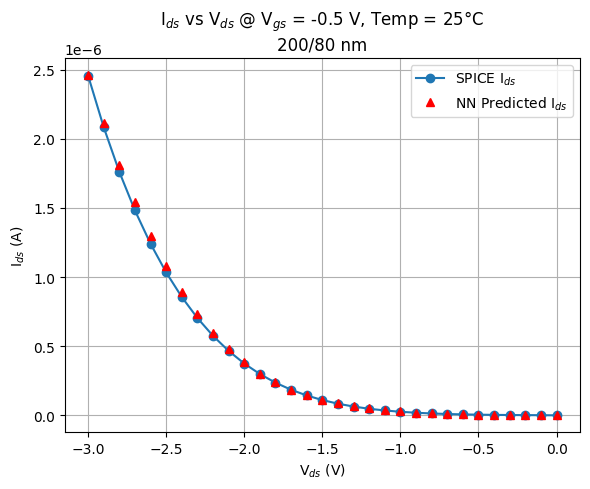

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


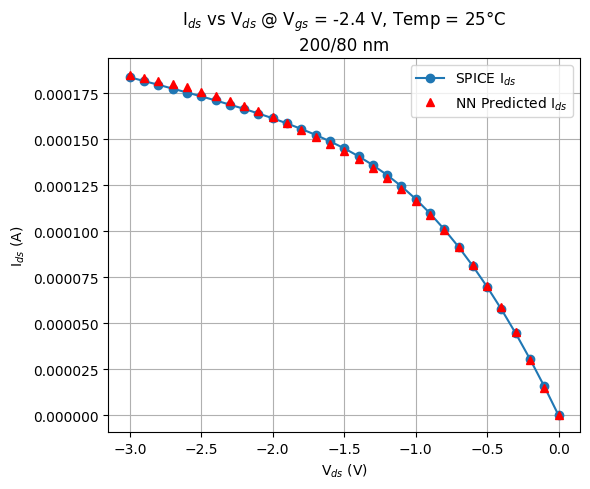

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


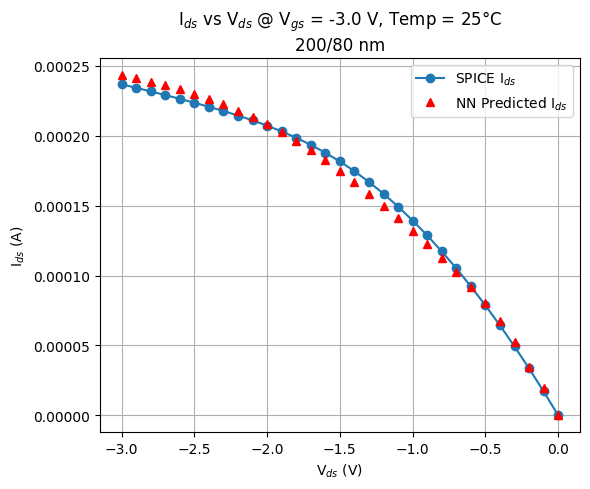

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/80 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


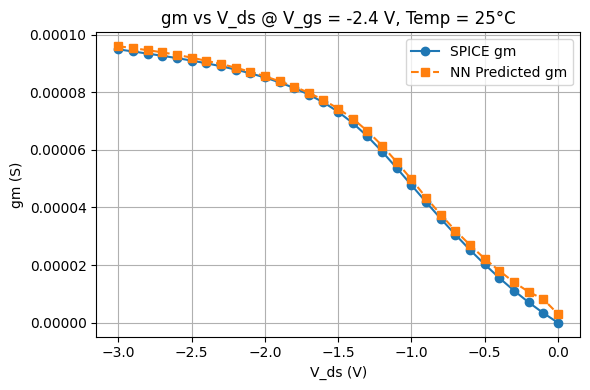

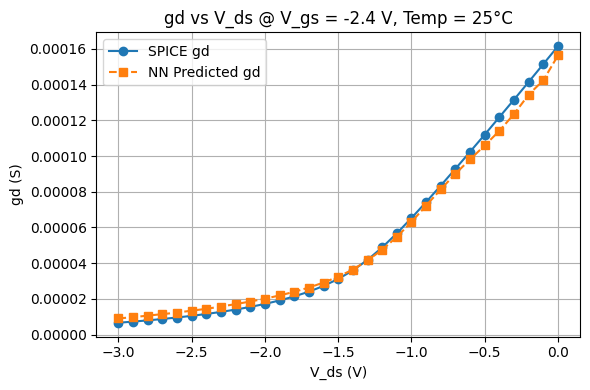

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set Vgs and temperature for comparison
VGS_TARGET = -2.4
TEMP_TARGET = 25

# Load and filter SPICE data
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
df_filtered = df_spice[mask].sort_values(by="Vds(V)")

if df_filtered.empty:
    print(f"⚠️ No data found for Vgs={VGS_TARGET} V, Temp={TEMP_TARGET}°C")
else:
    # Prepare input
    signature = device_signatures[2]  # Device 1
    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_plot_scaled = scaler.transform(X_plot)

    # Predict with model → outputs: [log10(Id), gm_scaled, gd_scaled]
    y_pred = model.predict(X_plot_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gd_pred_scaled = y_pred[:, 2]

    # Invert standard scaling
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()

    # True gm and gd
    gm_spice = df_filtered["gm"].values
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    # Plot gm
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gm_spice, "o-", label="SPICE gm")
    plt.plot(vds_vals, gm_pred, "s--", label="NN Predicted gm")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gm (S)")
    plt.title(f"gm vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot gd
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gd_spice, "o-", label="SPICE gd")
    plt.plot(vds_vals, gd_pred, "s--", label="NN Predicted gd")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gd (S)")
    plt.title(f"gd vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


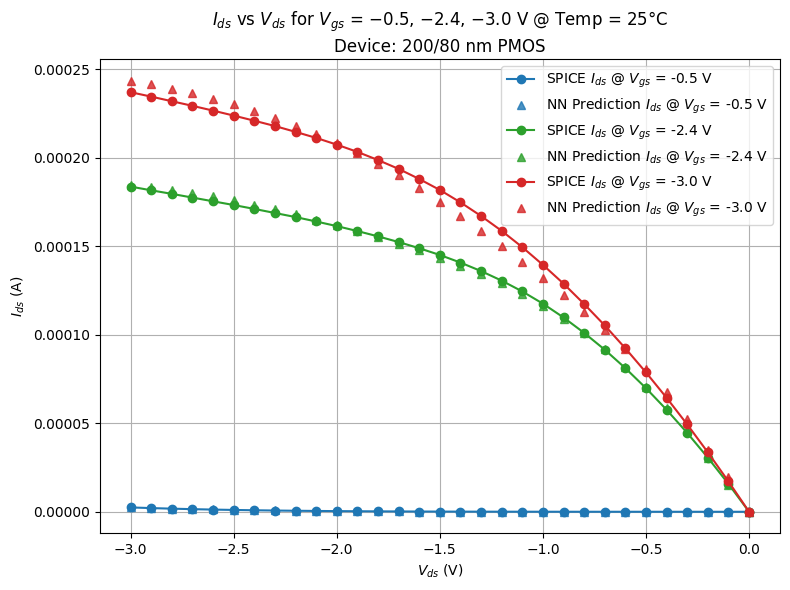

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/80 nm PMOS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


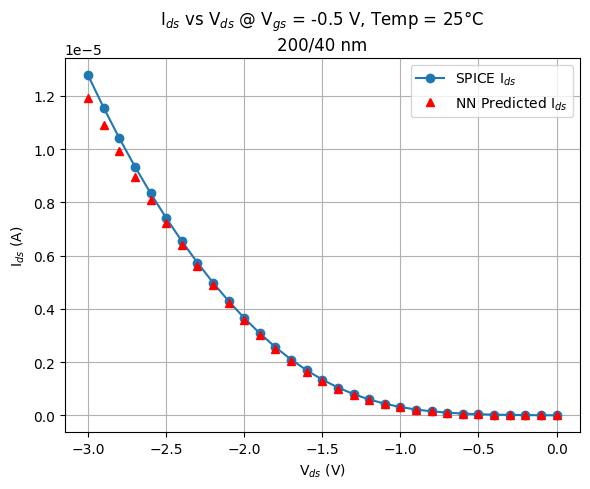

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


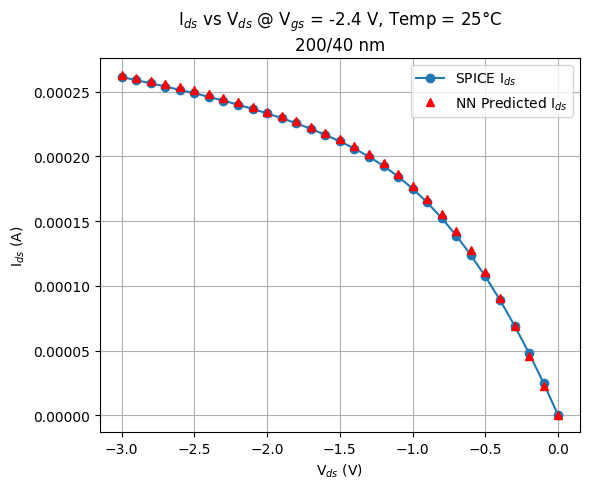

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


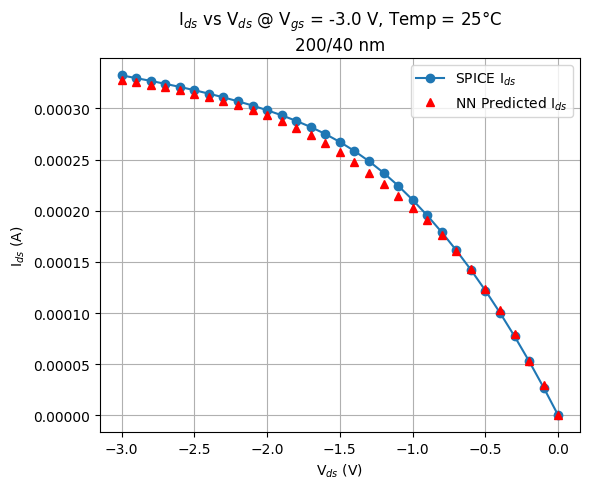

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


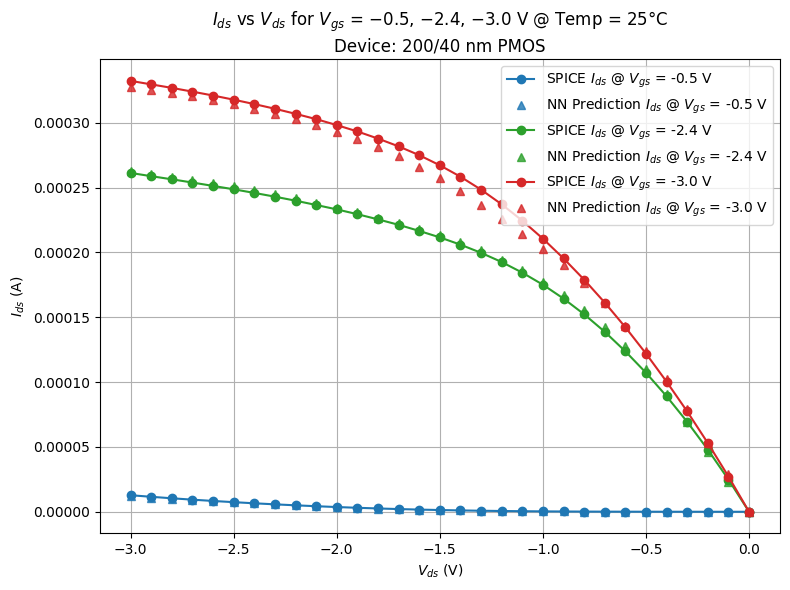

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


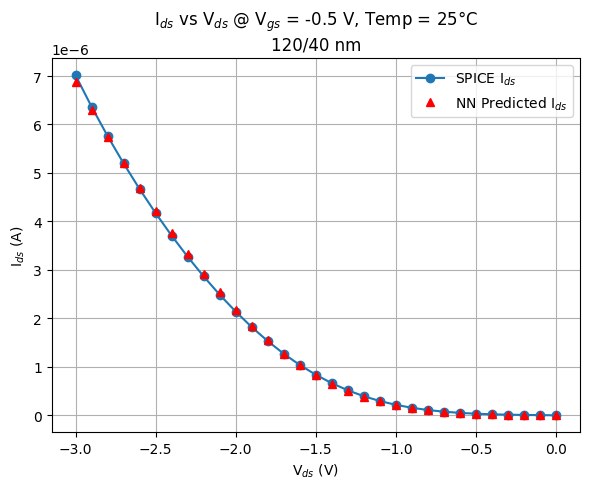

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


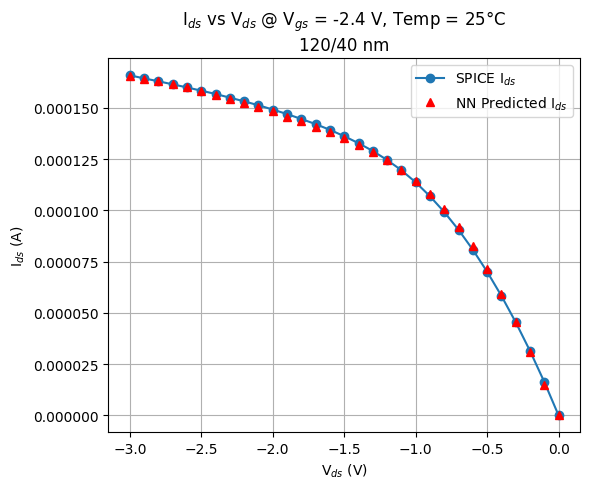

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


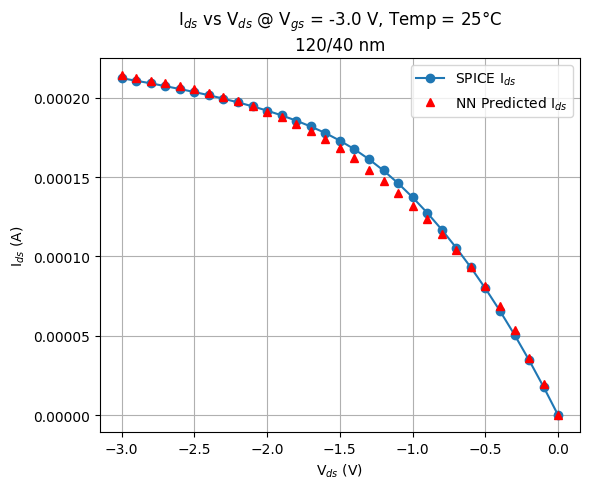

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n120/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


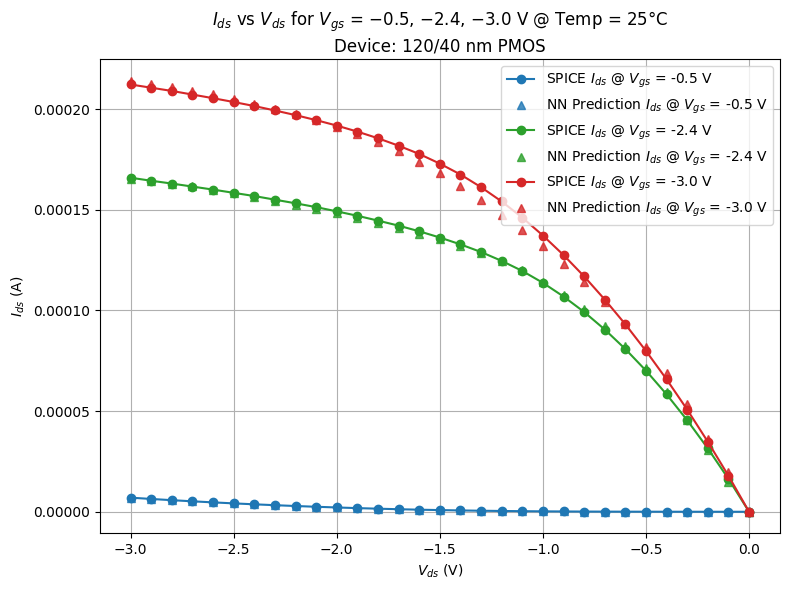

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 120/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


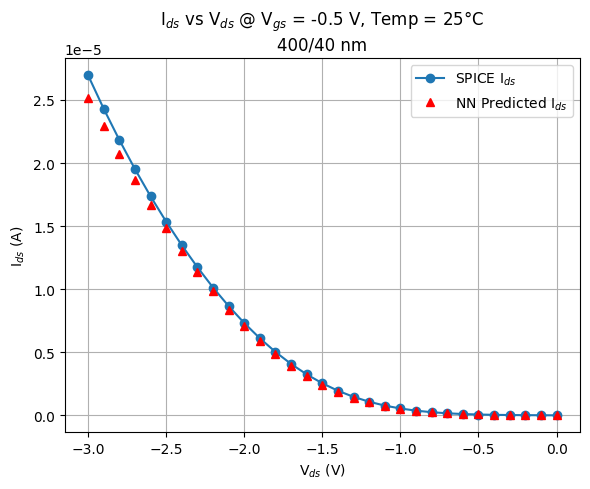

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


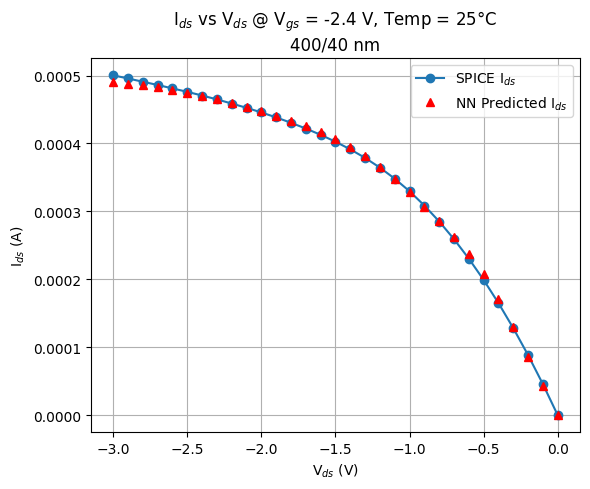

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


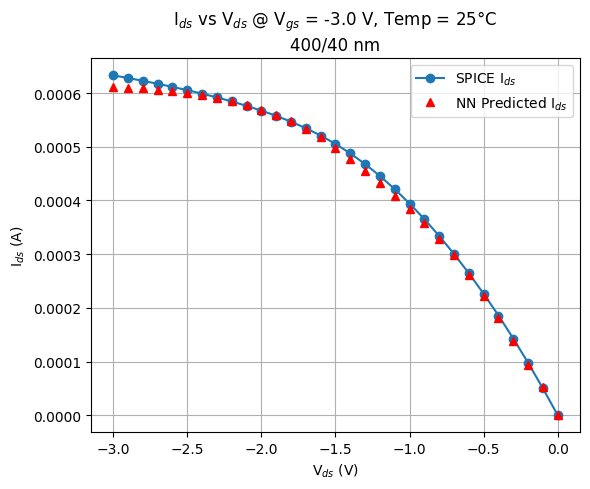

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n400/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


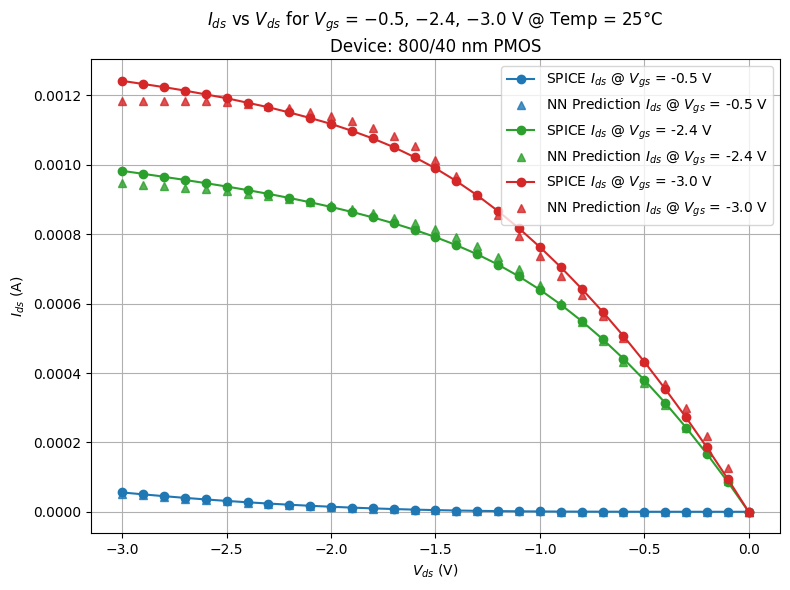

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 800/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


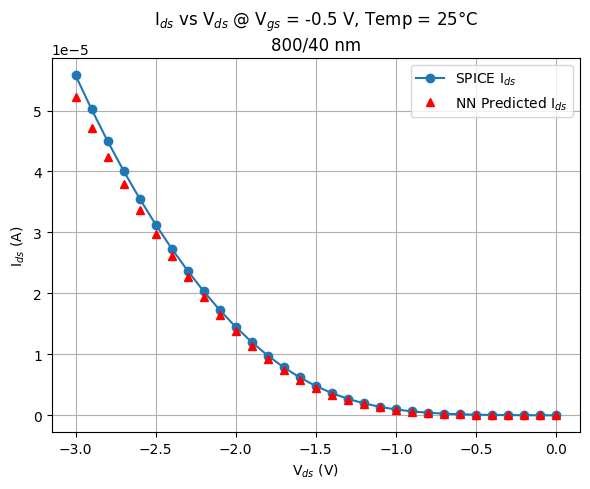

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


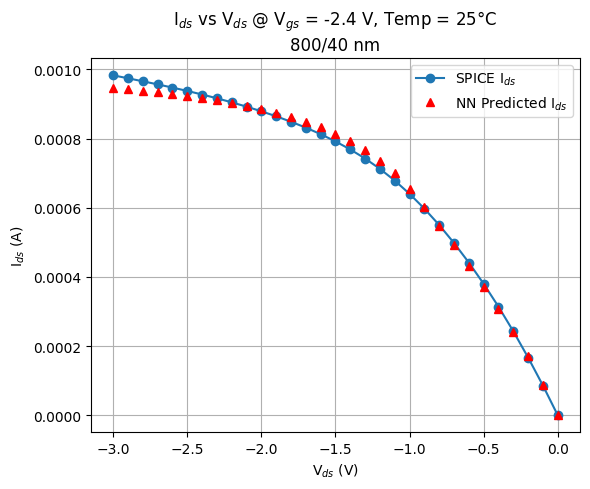

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


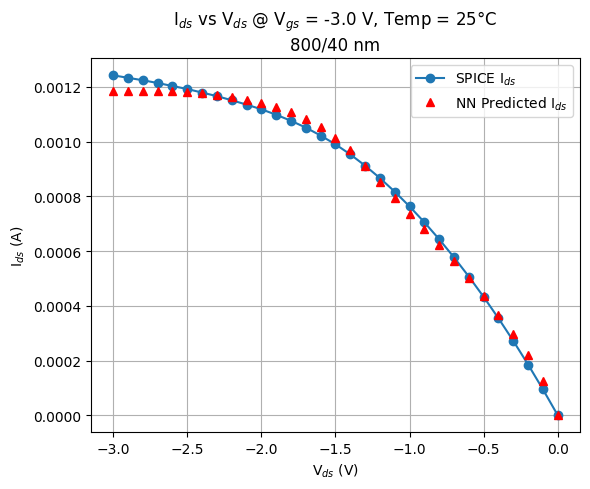

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n800/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


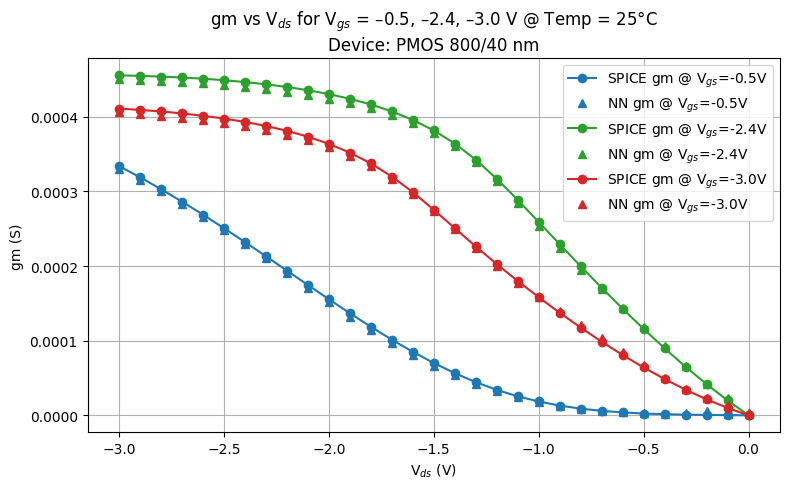

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4  # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


<Figure size 800x500 with 0 Axes>

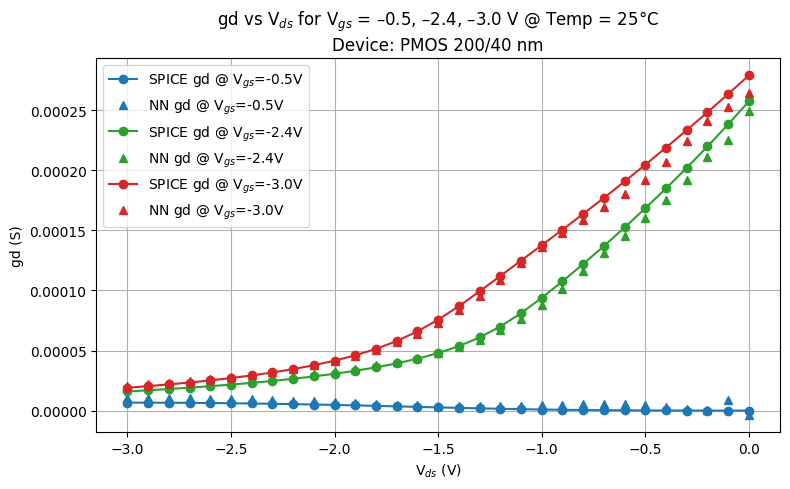

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 1 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 200/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


<Figure size 800x500 with 0 Axes>

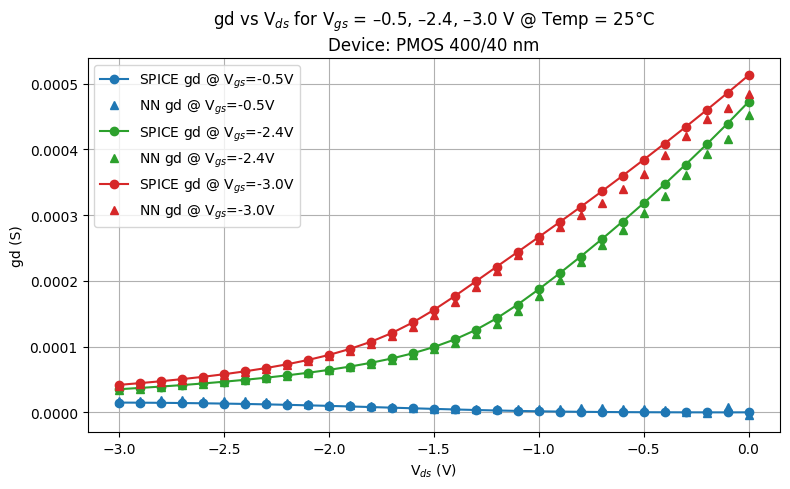

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 3 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 400/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


<Figure size 800x500 with 0 Axes>

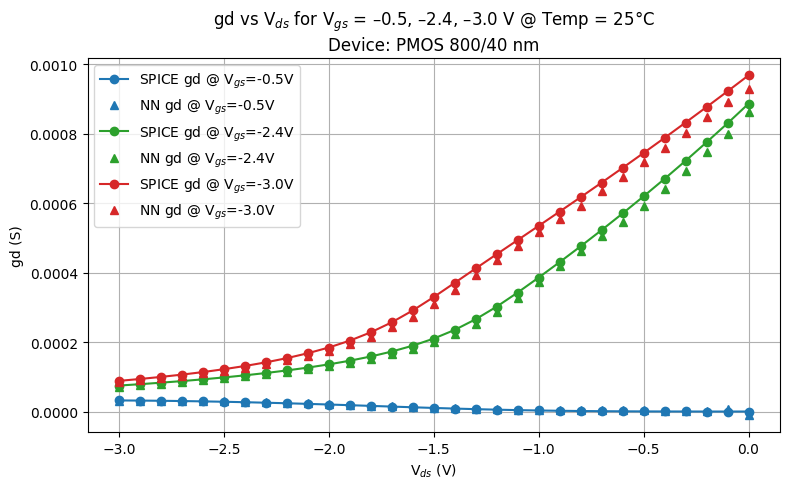

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


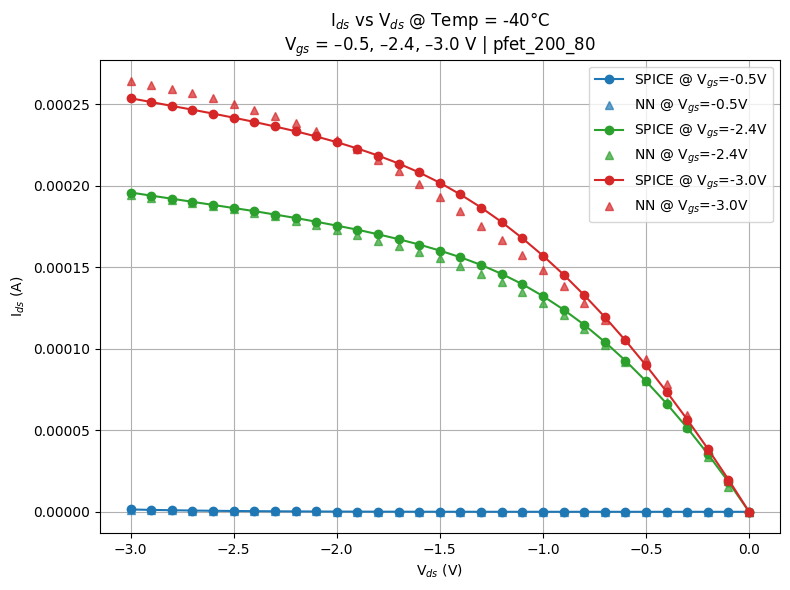

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


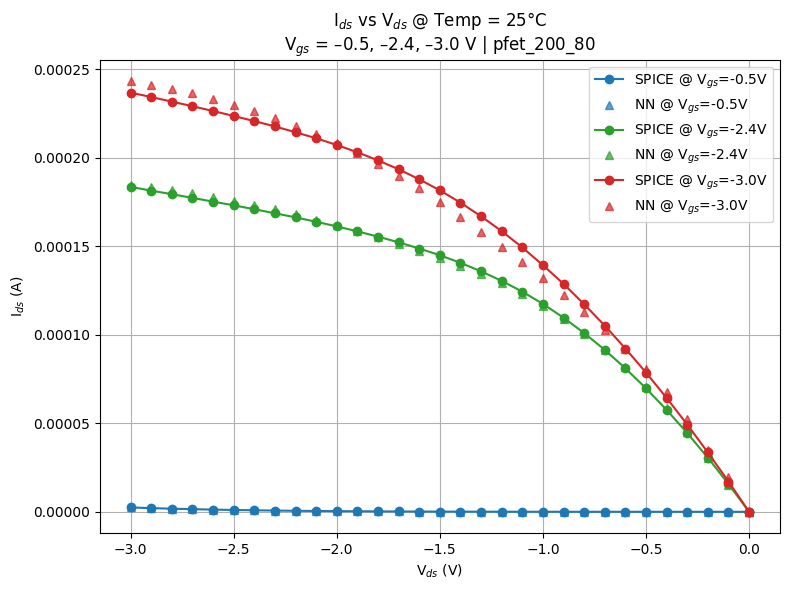

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


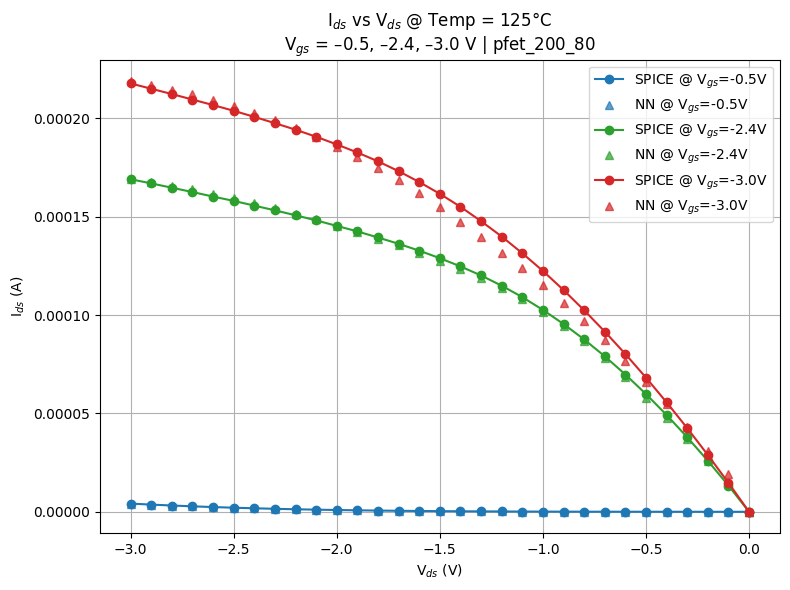

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 2  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_80.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_80")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


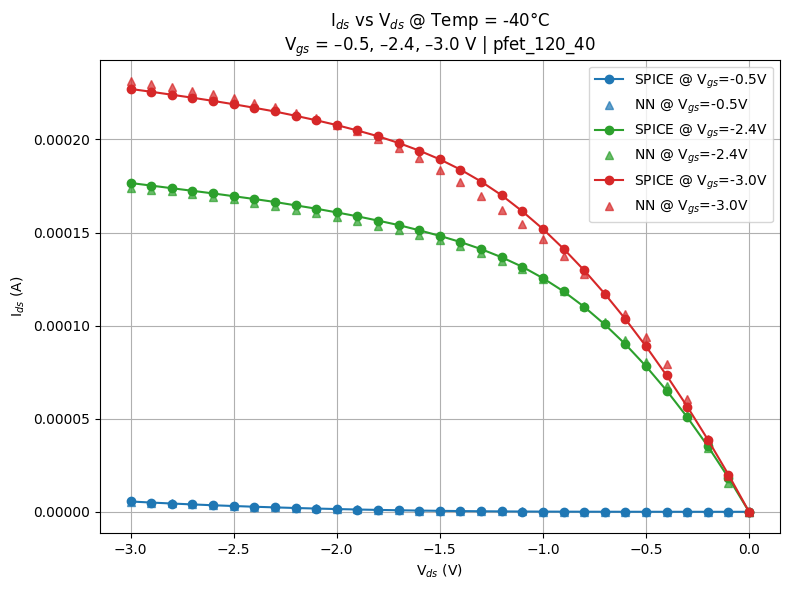

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


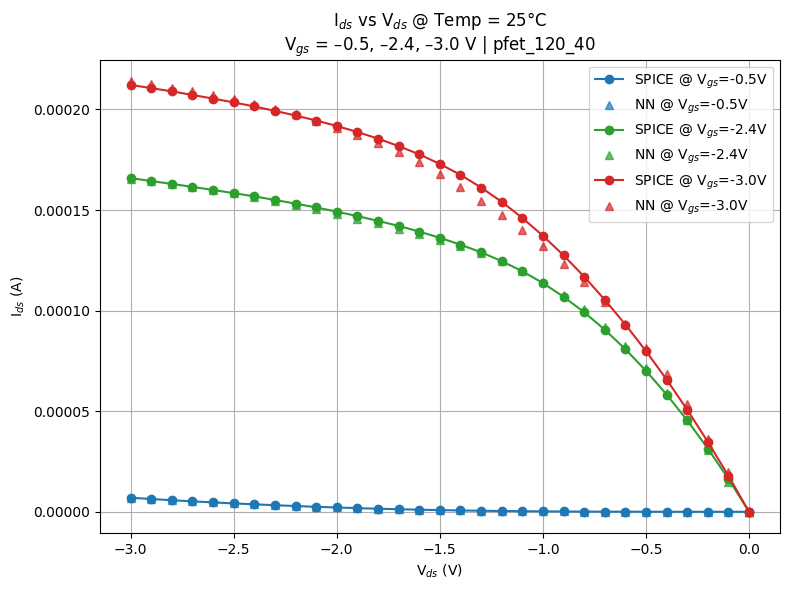

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


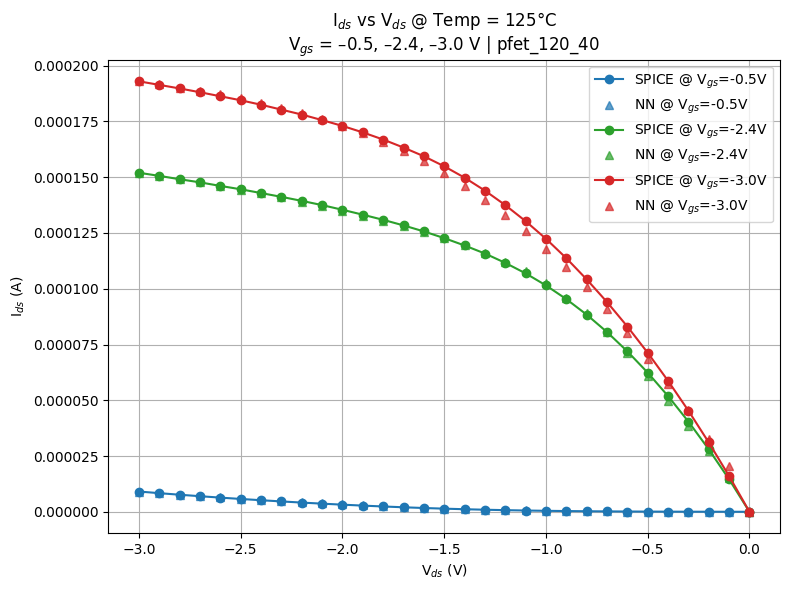

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 0  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_120_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_120_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


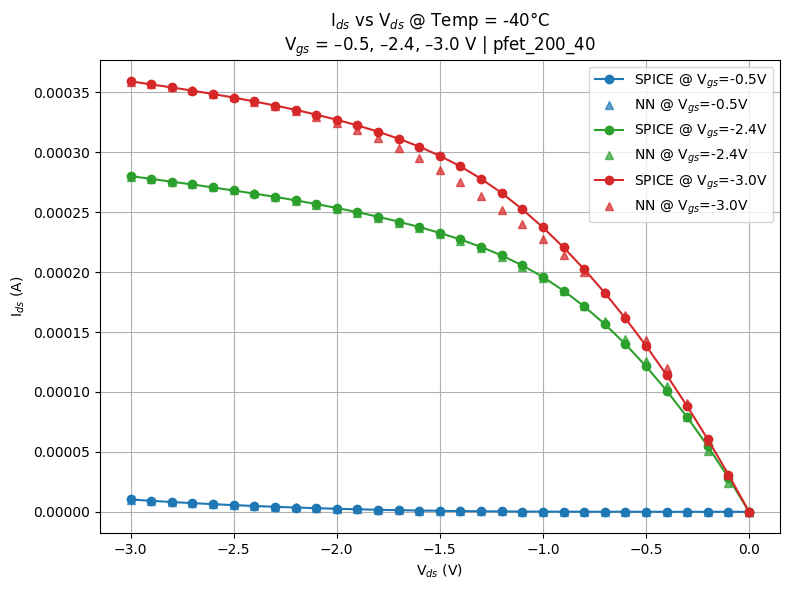

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


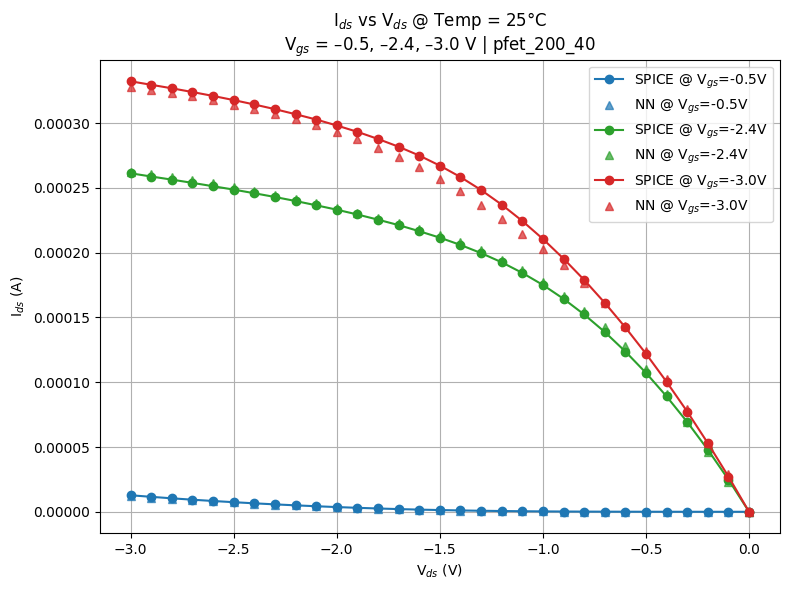

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


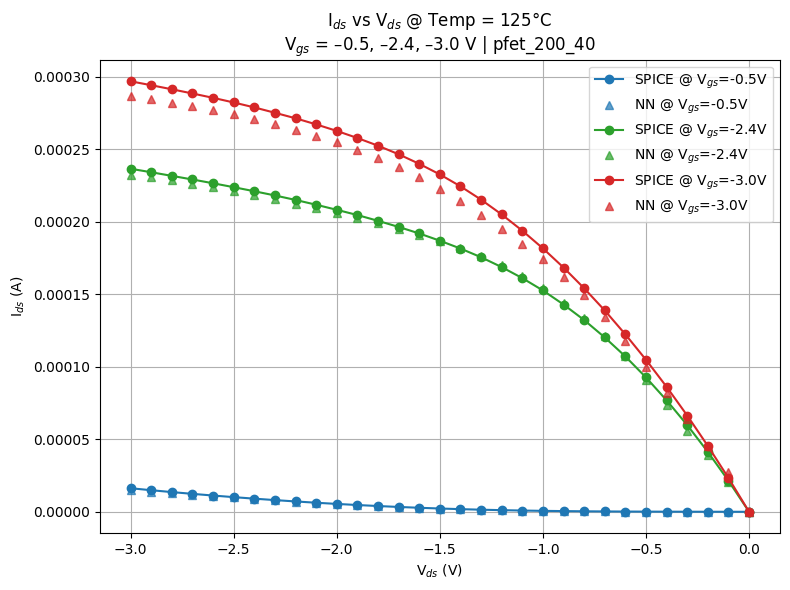

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 1  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


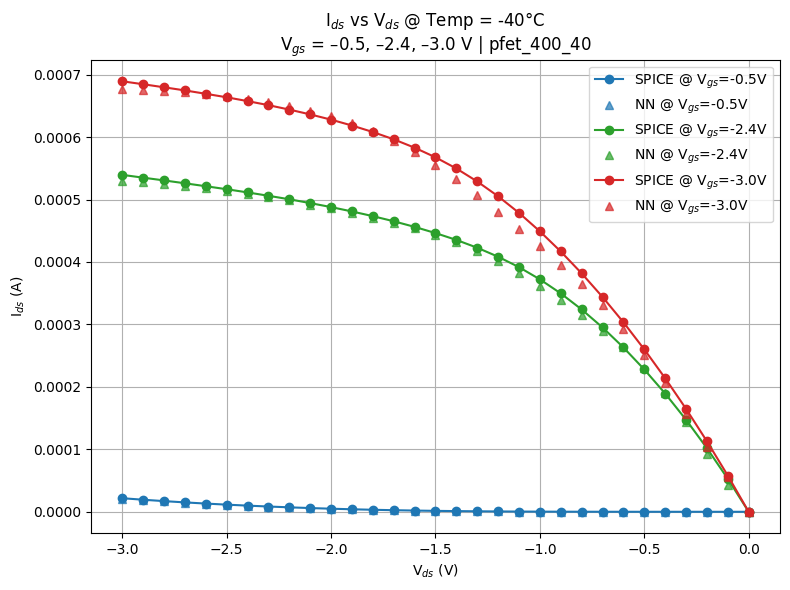

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


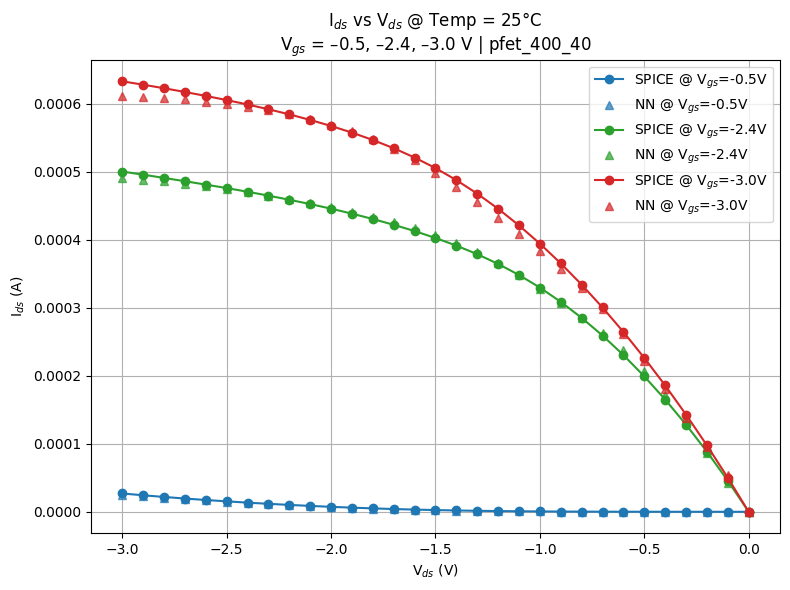

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


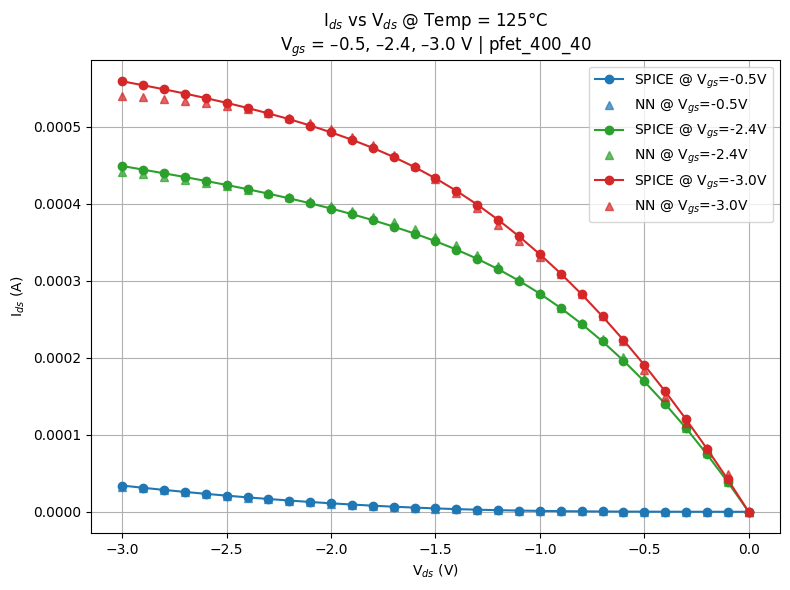

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 3  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_400_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


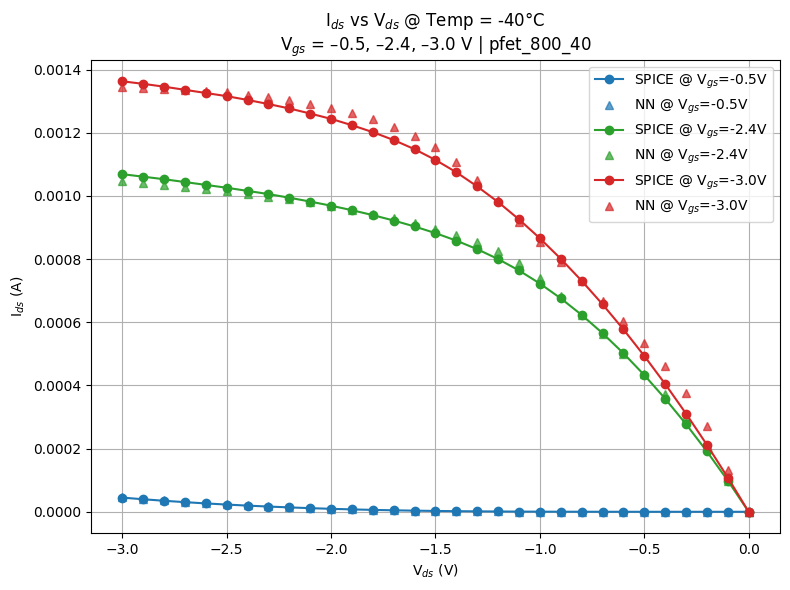

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


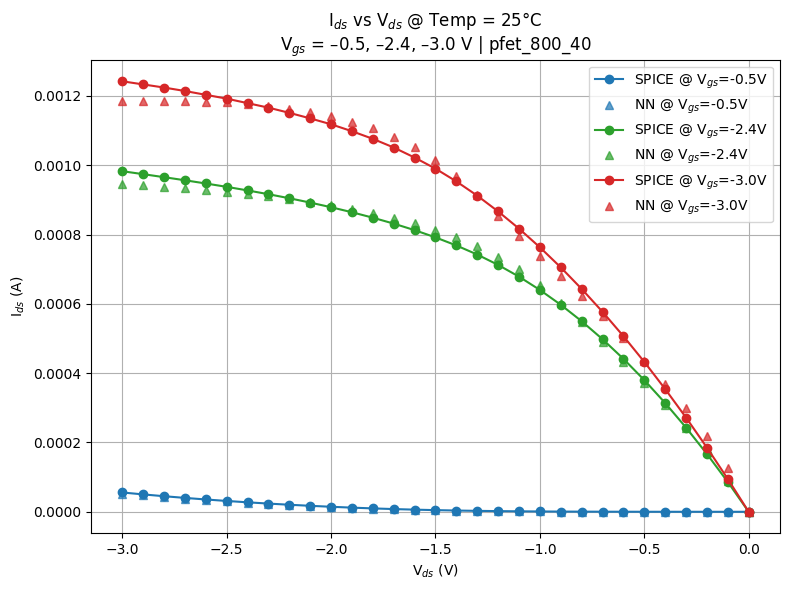

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


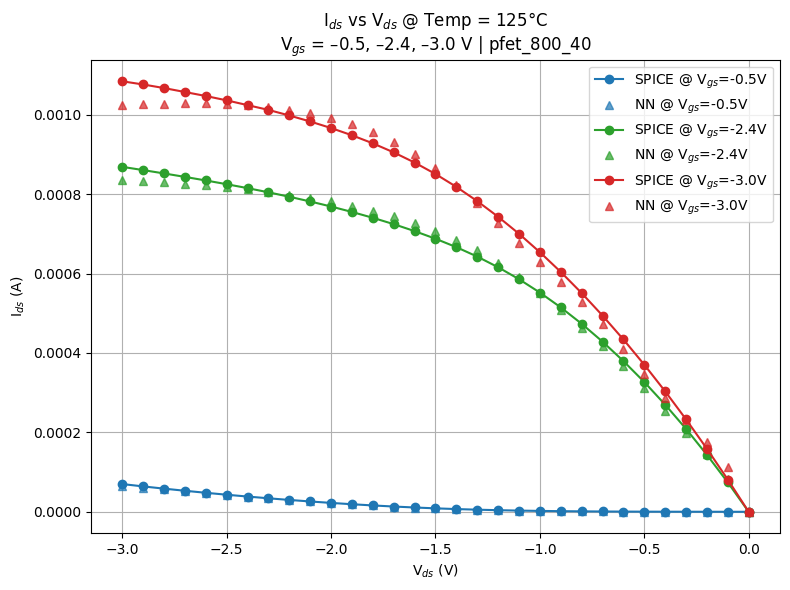

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 4  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_800_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


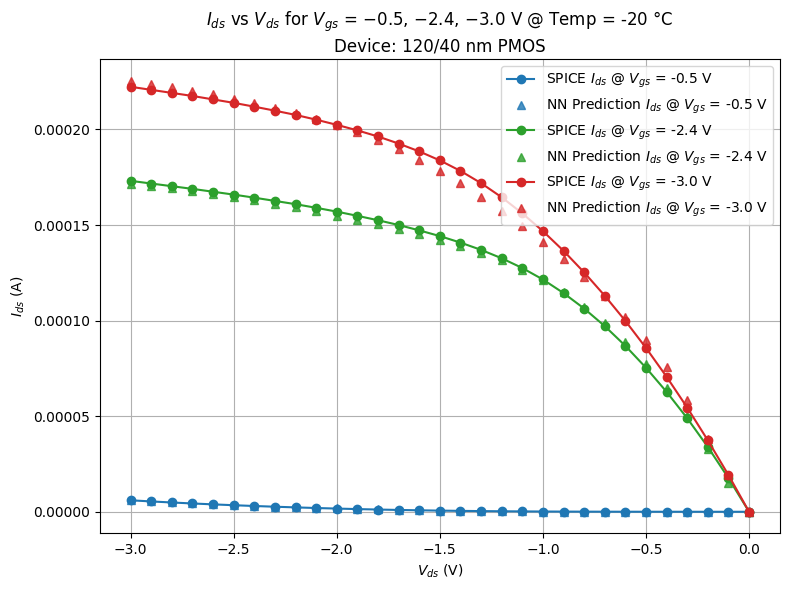

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


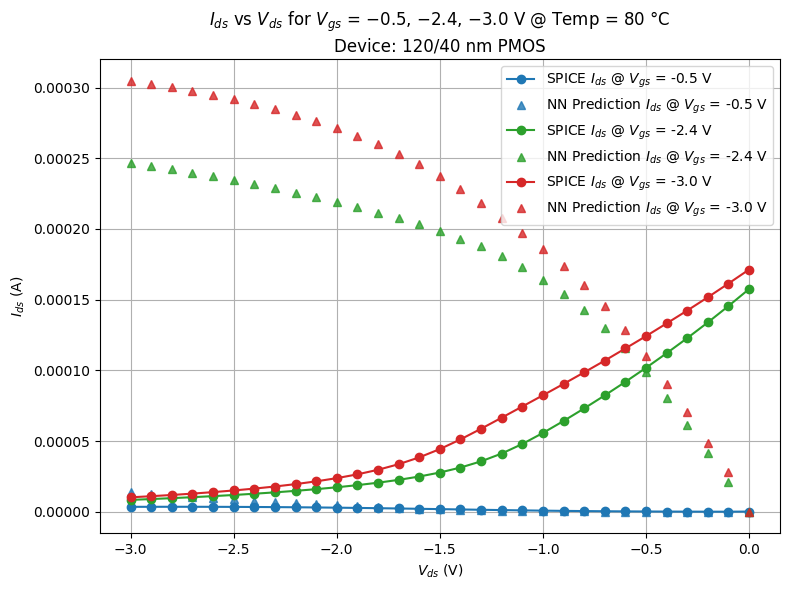

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


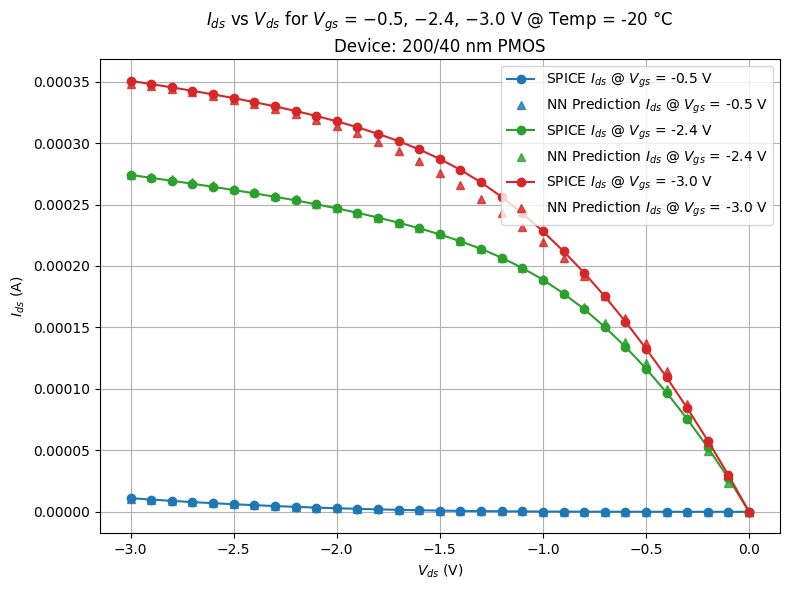

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


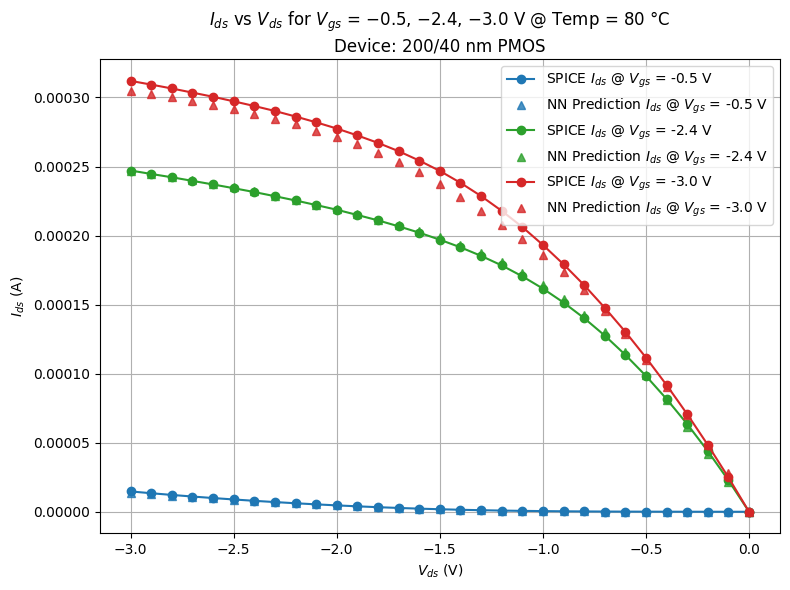

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


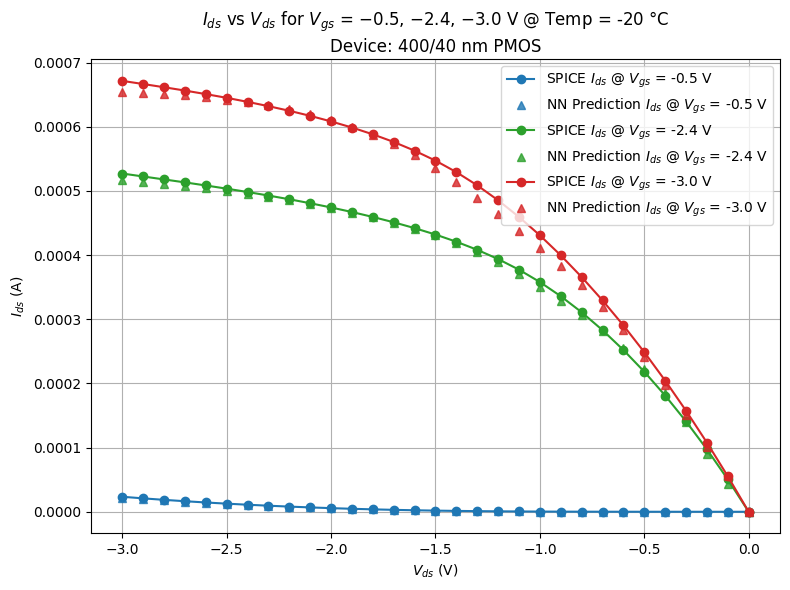

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


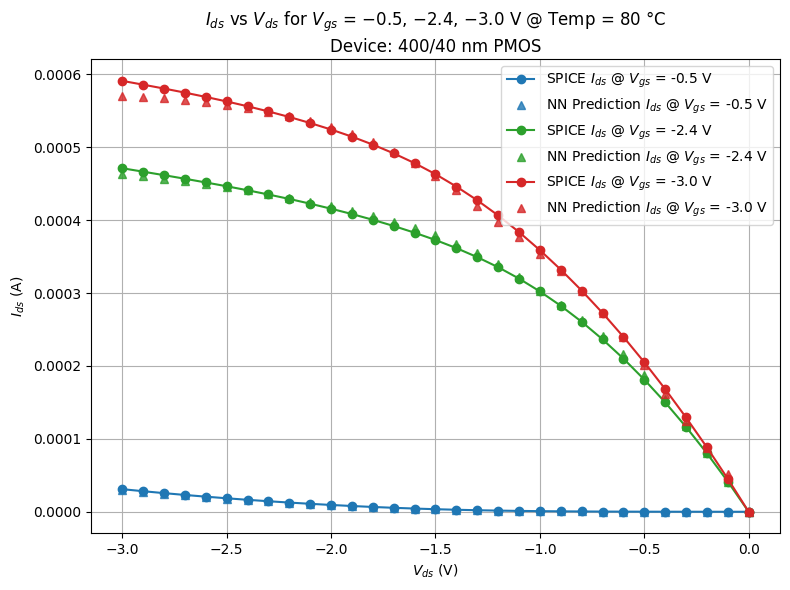

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


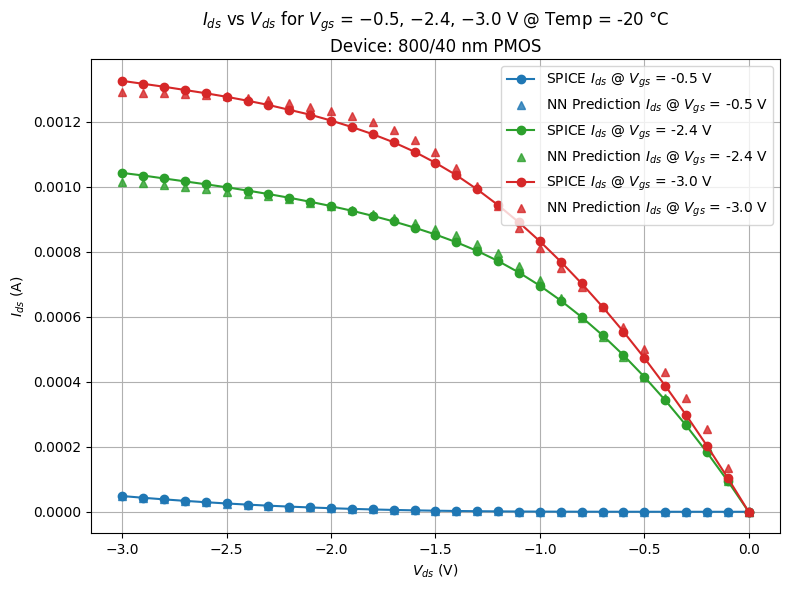

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


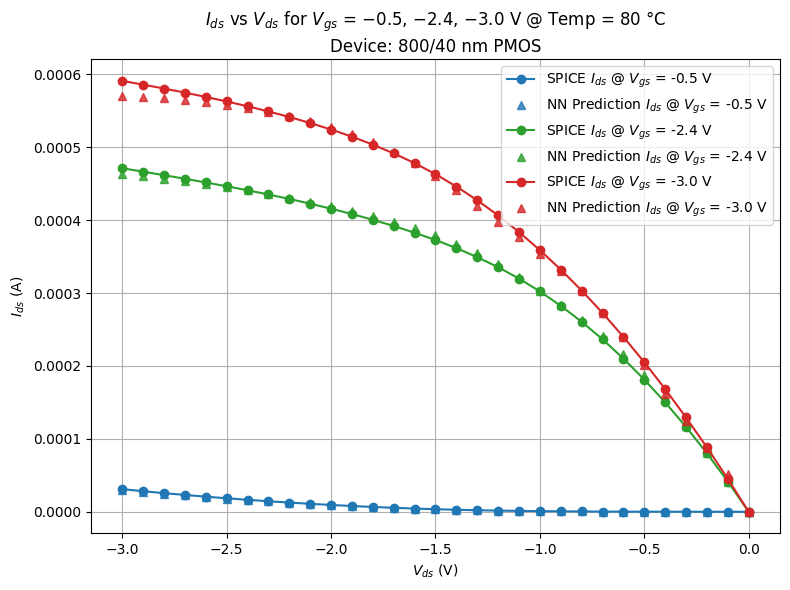

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()
